# Final Project: Exploring NFL Game Characteristics and Their Impact on Simple Gambling Outcomes

By Jon Woodland  
Date: 5/13/23


## Summary

This project aimed to explore the relationship between various game characteristics, such as weather conditions, distance traveled, week of play, stadium, teams' regional location, and certain gambling lines, in order to identify significant factors influencing the outcome of a game. The hypothesis was that by analyzing three main gambling lines in NFL games (Favorite, Over/Under, and Spread), it might be possible to identify patterns in everyday game characteristics that could improve the chances of making successful bets.

However, the process of data preparation and feature selection proved to be challenging and time-consuming. Multiple feature selection techniques, false discovery (FDR) methods, and feature reduction approaches were employed to identify relevant features and minimize noise. Several analysis methods were then applied using the generated feature lists. Surprisingly, most analysis methods yielded similar or slightly worse results than simply selecting the favorite. This finding was discouraging, suggesting that basic game features do not exhibit a strong correlation or significance with the outcome of a game.

Nonetheless, one analysis approach showed promise, although it was not extensively discussed in class and may be beyond the scope of this report. For reference, this analysis is included at the bottom of the report.

## Introduction
In light of the recent legalization of sports gambling in Massachusetts, the opportunity to wager on sports has become more accessible and convenient. The days of illegal sports gambling or 5 hour flights to Vegas are a thing of the past. As a result, I aim to investigate whether it is possible to develop an algorithm or identify specific factors that influence the outcome of a game. This project focuses on analyzing the relationship between various features and three key outcomes in NFL games: favorite winning, covering the point spread, and hitting the over/under.

Background:

To provide context, it is essential to understand the three main gambling outcomes involved in NFL games that will be used throughout this report. First, a team is considered a favorite when the odds of winning are higher for them compared to their opponent. Secondly, "covering the spread" refers to the point spread, which represents the number of points the favorite team is expected to win by. The point spread is typically denoted as a negative number. For instance, if the New England Patriots have a point spread of -3 against the New York Jets, they must win by more than 3 points to cover the spread. If they win by exactly 3 points, it is considered a "push," resulting in a tie, and both sides lose. Lastly, the "over/under" outcome focuses on the combined points scored by both teams. For example, if the odds indicate an over/under of 45 points, a combined score greater than 45 would result in hitting the over, while a score below 45 would hit the under. In the event of an exact score of 45, it is considered a push, and both sides lose.

Report Structure:

The following report will provide insights into the process of feature design, feature selection, feature reduction, attempted models, and the analysis of those models. By examining these aspects, we aim to identify meaningful relationships between various game characteristics and the aforementioned outcomes. Which you will see did not come to fruition.

## Data Mining And Processing

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import concurrent.futures

from typing import Tuple, List

from scipy.stats import chi2_contingency, ttest_ind, pearsonr
from statsmodels.stats.multitest import multipletests

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, RFECV
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans, MiniBatchKMeans

import xgboost as xgb


In [3]:
# Read the stadium data file into a data frame
stadium = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/nfl_stadiums.csv')

In [4]:
# Read the team data file into a data frame
teams = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/nfl_teams.csv')

In [5]:
# Read the team data file into a data frame
spreads = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/spreadspoke_scores.csv')

In [6]:
# Convert schedule date to be a date for further investigation and data clean up
spreads['schedule_date'] = pd.to_datetime(spreads['schedule_date'])

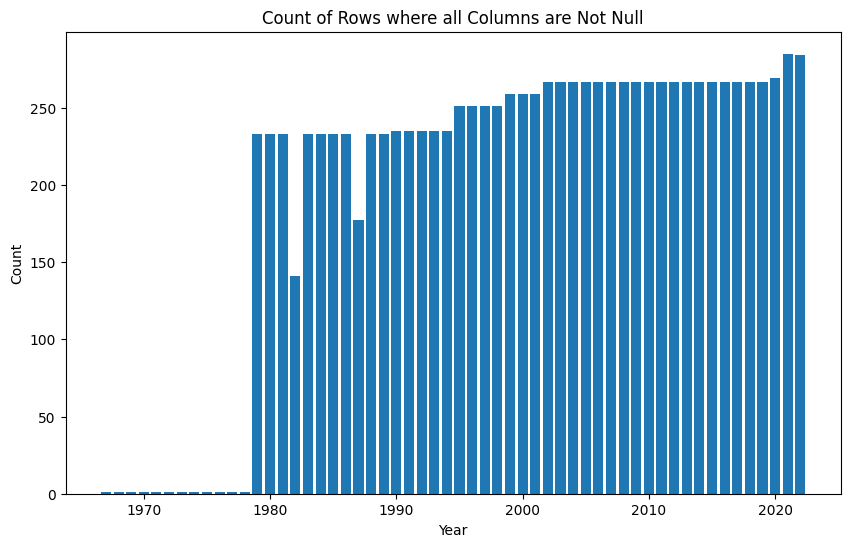

In [7]:
# Create a mask to filter for rows where all three columns are not null
mask = (spreads['team_favorite_id'].notnull()) & (spreads['spread_favorite'].notnull()) & (spreads['over_under_line'].notnull())

# Count the number of occurrences where the mask is true for each year
yearly_counts = spreads[mask]['schedule_season'].value_counts().sort_index()

# Plotting the diagram
plt.figure(figsize=(10, 6))
plt.bar(yearly_counts.index, yearly_counts.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Rows where all Columns are Not Null')
plt.show()


As you can see above, we consistently start to see all three target gambling fields being populated starting in 1979. Our dataframe will be reduced to games within 1979 and 2022.

In [8]:
# Filter the spread df to be every game from 9/1/1979 on and create a new df
filtered_spreads_df = spreads[spreads['schedule_date'] >= '1979-09-01']

In [10]:
# Read in the stadium data again but this time select only the desired columns
stadium_df = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/nfl_stadiums.csv')[['stadium_name', 'stadium_location',
       'stadium_type', 'stadium_weather_type', 'stadium_capacity', 'stadium_surface']]

# Merge the two dataframes on the 'stadium' and 'stadium_name' columns using a left join
merged_df = pd.merge(filtered_spreads_df, stadium_df, left_on='stadium', right_on='stadium_name', how='left')

# drop the redundant 'stadium_name' column
merged_df.drop('stadium_name', axis=1, inplace=True)


Currently, the favorite team in the spread dataframe is represented by an ID (e.g., NE for New England Patriots). However, the teams dataframe contains the actual names of the teams, which can be used to join and retrieve the favorite team's actual name. By leveraging this information, we can enhance the readability and interpretability of the data by replacing the ID with the corresponding team name.

In [12]:
# Create a new dataframe for teams data and only select the columns I need
teams_df = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/nfl_teams.csv')[['team_name','team_id']]

# Merge the two dataframes on the 'team_id' and 'team_favorite_id' columns using a left join
final_merged_df = pd.merge(merged_df, teams_df, left_on='team_favorite_id', right_on='team_id', how='left')

# Filter the final_merged_df using the following logic.
# If the team ID = team_favorite_id AND the team name == either the away team or home team then keep that row
# I did this because the teams dataframe has duplicates because of teams moving or changing names but keeping the same ID
favorite_team_mask = ((final_merged_df['team_favorite_id'] == final_merged_df['team_id']) & ((final_merged_df['team_home'] == final_merged_df['team_name']) | (final_merged_df['team_away'] == final_merged_df['team_name']))) | (final_merged_df['team_favorite_id'].isnull()) | (final_merged_df['team_favorite_id'] == 'PICK')
final_merged_df = final_merged_df[favorite_team_mask]

# Rename the 'team_name' column to 'favorite_team'
final_merged_df = final_merged_df.rename(columns={'team_name': 'favorite_team'})

# Drop the redundant 'team_id' column
final_merged_df.drop('team_id', axis=1, inplace=True)

### Feature Creation

Now that we have merged our first three datasets into one dataframe, we can proceed with calculating some fields and creating new features that will be valuable for our analysis. The first step is to calculate the winning team by comparing the two scores and assigning the home or away team name based on which score is higher. In the event that both scores are equal, we will designate the value "tie."

In [14]:
# Add a new column 'winning_team' to the DataFrame based on the game scores
final_merged_df['winning_team'] = final_merged_df.apply(lambda row: row['team_home'] if row['score_home'] > row['score_away'] else
                                                       row['team_away'] if row['score_away'] > row['score_home'] else 'tie',
                                                       axis=1)


Next, we will develop a method to determine whether the favorite team covered the score, assigning enum values of "Yes," "No," or "Push." Subsequently, I executed the function and added the newly calculated field to the dataframe.

In [15]:
# Create a method that calculates whether the favorite team covered the spread and applies it to a new column in the dataframe
def did_favorite_cover(row):
    if row['winning_team'] != row['favorite_team']:
        return 'No'
    elif abs(row['score_home'] - row['score_away']) > abs(row['spread_favorite']):
        return 'Yes'
    elif abs(row['score_home'] - row['score_away']) < abs(row['spread_favorite']):
        return 'No'
    elif abs(row['score_home'] - row['score_away']) == abs(row['spread_favorite']):
        return 'Push'

# Apply the function to each row of the dataframe and store the result in a new column
final_merged_df['did_favorite_cover_spread'] = final_merged_df.apply(did_favorite_cover, axis=1)


Next, we will devise a method to ascertain whether the favorite team won, assigning enum values of "Favorite," "Tie," or "Underdog." Following this, I executed the function and added the newly computed field to the dataframe.

In [16]:
# Create a method to identify the favorite status and apply it to a new column in the dataframe
def get_favorite_status(row):
    if (row['winning_team'] == row['favorite_team']) and (row['winning_team'] != 'tie'):
        return 'Favorite'
    elif row['winning_team'] == 'tie':
        return 'Tie'
    else:
        return 'Underdog'

# Apply the function to each row of the dataframe and store the result in a new column
final_merged_df['favorite_status'] = final_merged_df.apply(get_favorite_status, axis=1)


Next, we will develop a method to determine the over/under status of the game, assigning enum values of "Over," "Under," or "Push." Subsequently, I executed the function and added the newly calculated field to the dataframe.

In [17]:
# Create a method to identify the over/under outcome and apply it to a new column in the dataframe

# The dataframe had some blank spaces in the 'over_under_line' column, so I replaced them with NaN
final_merged_df['over_under_line'] = final_merged_df['over_under_line'].replace(' ', np.nan).astype(float)

def get_over_under_status(row):
    if np.isnan(row['over_under_line']):
        return np.nan
    elif row['score_home'] + row['score_away'] > row['over_under_line']:
        return 'Over'
    elif row['score_home'] + row['score_away'] < row['over_under_line']:
        return 'Under'
    else:
        return 'Push'

# Apply the get_over_under_status() method to each row of the dataframe and store the result in a new column 'over_under_status'
final_merged_df['over_under_status'] = final_merged_df.apply(get_over_under_status, axis=1)


Next, we can proceed with determining the distance traveled by the visiting team. This process involved several steps:

1. Created a mapping table to identify the home field for each team in each schedule season, excluding neutral site games.
2. Merged the mapping table with the final_merged_df dataframe using the schedule year and matching the team name with the away team.
3. Added a new column for the away team address in the final_merged_df.
4. Utilized the Google API to calculate the distance between the home team location and the away team location.
5. Added the calculated distance as a new column in the final_merged_df.
6. Applied necessary cleanup to the received distance field to ensure consistency and readability.

By completing these steps, we will be able to incorporate the distance traveled by the visiting team as a valuable feature in our analysis.

In [18]:
# Create a mapping to identify home stadiums for each schedule_season

# Filter the dataframe to include only rows where 'stadium_neutral' is False
mapping = final_merged_df.loc[final_merged_df['stadium_neutral'] == False, ['schedule_season', 'team_home', 'stadium_location']]

# Remove duplicate rows based on 'schedule_season', 'team_home', and 'stadium_location' columns
mapping = mapping.drop_duplicates()

# Rename the 'schedule_season', 'team_home', and 'stadium_location' columns for clarity
mapping = mapping.rename(columns={'schedule_season': 'season', 'team_home': 'team_name', 'stadium_location': 'team_location'})


In [19]:
# Merge the mapping dataframe with clean_filtered_df based on 'schedule_season' and 'team_away' columns
final_merged_df = pd.merge(final_merged_df, mapping, left_on=['schedule_season', 'team_away'], right_on=['season', 'team_name'])

# Select the 'team_location' column from the merged dataframe and assign it to the 'away_team_address' column of clean_filtered_df
final_merged_df['away_team_address'] = final_merged_df['team_location']


In [20]:
# Drop redundant columns from merge
final_merged_df = final_merged_df.drop('team_name', axis=1)
final_merged_df = final_merged_df.drop('season', axis=1)

In [21]:
# Now we calculate the distance of non neutral site games. We use address based on city granularity
# This code paralel process api calls for great speed

# Define a function to calculate distance between two addresses using Google Map API
def calculate_distance(origin, destination, api_key):
    url = "https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins={}&destinations={}&key={}".format(origin, destination, api_key)
    response = requests.get(url).json()
    try:
        distance = response['rows'][0]['elements'][0]['distance']['text']
        return distance
    except KeyError:
        print("Error: Distance not found in response")
        return None
    
def calculate_distance_parallel(args):
    origin, destination, api_key = args
    return calculate_distance(origin, destination, api_key)

# Add a new column 'distance_traveled'
if 'distance_traveled' not in final_merged_df:
    final_merged_df['distance_traveled'] = np.nan

# Collect arguments for parallel processing
args_list = []
for index, row in final_merged_df.iterrows():
    if pd.isnull(row['distance_traveled']):
        origin = row['stadium_location']
        destination = row['away_team_address']
        api_key = '[redacted]' # Removed my api key for security purposed
        args_list.append((origin, destination, api_key))

# Use multiprocessing to calculate distances in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = executor.map(calculate_distance_parallel, args_list)

# Update the 'distance_traveled' column with the calculated distances
for index, result in zip(final_merged_df.index, results):
    if result is not None:
        final_merged_df.at[index, 'distance_traveled'] = result


Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Distance not found in response
Error: Dista

In [7]:
# Prep the distance traveled column

# find columns with "ft" and replace entire value with 0
df.loc[df['distance_traveled'].str.contains('ft', na=False).fillna(False), 'distance_traveled'] = '0'

# delete mi from row fields
df['distance_traveled'] = df['distance_traveled'].str.replace('mi', '')

# strip column
df['distance_traveled'] = df['distance_traveled'].str.strip()

# replace commas
df['distance_traveled'] = df['distance_traveled'].str.replace(',', '').astype(float)

Next, we focus on ensuring that we have sufficient weather data for our analysis. To assess this, we obtained the counts and percentage of null values for the weather columns in the dataset. This allows us to evaluate the availability and completeness of weather information in our dataset.

In [22]:
# Count and calculate the percentage of missing values for each column
missing_counts = df[['weather_temperature', 'weather_wind_mph', 'weather_humidity', 'weather_detail']].isnull().sum()
percent_missing = (missing_counts / len(df)) * 100

# Display the results
print("Missing Value Counts:")
print(missing_counts)
print("\nPercentage of Missing Values:")
print(percent_missing)


Missing Value Counts:
weather_temperature     977
weather_wind_mph        993
weather_humidity       4668
weather_detail         8269
dtype: int64

Percentage of Missing Values:
weather_temperature     8.856858
weather_wind_mph        9.001904
weather_humidity       42.317106
weather_detail         74.961472
dtype: float64


Upon examining the weather_detail and weather_humidity columns, it becomes apparent that the data in these columns is quite sparse. In order to address this issue and obtain more comprehensive weather data, I discovered an alternative data source that could serve as a valuable supplement. The data source, available at https://github.com/Nolanole/NFL-Weather-Project/blob/master/all_games_weather.csv, provides game-specific weather data spanning from 1980 to 2018. This extended time range should effectively cover a significant portion of our dataset and enhance the availability of weather information for our analysis.

In [23]:
# Store url as variable
weather_url = 'https://raw.githubusercontent.com/Nolanole/NFL-Weather-Project/master/all_games_weather.csv'
# Read in csv url to weather dataframe
weather = pd.read_csv(weather_url)

In [24]:
# Drop unnecessary columns from the weather dataframe
weather = weather.drop([ 'score_home', 'score_away', 'game_id', 'stadium', 'avg_temp', 'avg_dewpoint',
       'avg_humidity', 'avg_wind', 'max_windgust'], axis=1)

In [25]:
# Cast date field in the weather dataframe to date type
weather['date'] = pd.to_datetime(weather['date'])

In [26]:
# Merge the two dataframes together
df = pd.merge(df, weather, how='left', left_on=['team_home', 'team_away', 'schedule_date'], right_on=['home', 'away', 'date'])

In [27]:
# Drop unnecessary columns from the dataframe
df = df.drop([ 'home', 'date', 'away'], axis=1)

In [28]:
# Remove unnamed column from dataframe
df = df.drop(columns=[col for col in df.columns if 'Unnamed' in col])


In [9]:
def count_missing_values(df, column_name):
    """
    Count the number of missing values in a specific column of a DataFrame.

    Args:
        df (DataFrame): The DataFrame to analyze.
        column_name (str): The name of the column to count missing values in.

    Returns:
        int: The number of missing values in the specified column.

    """
    # Count the number of missing values in the column
    num_missing = df[column_name].isna().sum()

    # Check if there are no missing values
    if num_missing == 0:
        return 0
    else:
        # Print the number of missing values for the column
        print(f'The "{column_name}" column has {num_missing} missing values.')

        # Return the number of missing values
        return num_missing


Next, we will proceed with removing columns that contain a majority of missing data. I have set the threshold at 40% missing values, meaning any column with missing values exceeding this threshold will be removed from the dataset. This step aims to eliminate columns that may not contribute significantly to our analysis due to their limited availability of data.

In [10]:
# Loop through all columns and drop columns with more than 40% missing values
for col in df.columns:
    # Calculate the percentage of missing values in the column
    percent_missing = df[col].isna().mean() * 100

    if percent_missing > 40:
        # Drop the column if the percentage of missing values is greater than 40
        print(f'{col}: {percent_missing:.2f}% missing values, dropping column')
        df.drop(col, axis=1, inplace=True)
    else:
        # Keep the column if the percentage of missing values is not greater than 40
        print(f'{col}: {percent_missing:.2f}% missing values, keeping column')

schedule_date: 0.00% missing values, keeping column
schedule_season: 0.00% missing values, keeping column
schedule_week: 0.00% missing values, keeping column
schedule_playoff: 0.00% missing values, keeping column
team_home: 0.00% missing values, keeping column
score_home: 0.00% missing values, keeping column
score_away: 0.00% missing values, keeping column
team_away: 0.00% missing values, keeping column
team_favorite_id: 0.00% missing values, keeping column
spread_favorite: 0.00% missing values, keeping column
over_under_line: 0.56% missing values, keeping column
stadium: 0.00% missing values, keeping column
stadium_neutral: 0.00% missing values, keeping column
weather_temperature: 8.86% missing values, keeping column
weather_wind_mph: 9.00% missing values, keeping column
weather_humidity: 42.32% missing values, dropping column
weather_detail: 74.96% missing values, dropping column
stadium_location: 0.06% missing values, keeping column
stadium_type: 0.21% missing values, keeping column

Now that we have removed columns that were too sparse, we will now remove NaN rows.

In [11]:
def print_distinct_values(df):
    """
    Print the distinct (unique) values in each column of a DataFrame.

    Args:
        df (DataFrame): The DataFrame to analyze.

    """
    for col in df.columns:
        # Print the column name
        print('\n' + col)

        # Print the distinct values in the column
        print(df[col].unique())


In [12]:
print_distinct_values(df)


schedule_date
['1979-09-01' '1979-09-16' '1979-10-07' ... '2022-09-26' '2022-12-29'
 '2023-01-16']

schedule_season
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022]

schedule_week
['1' '3' '6' '7' '8' '10' '12' '14' '5' '13' '15' 'Division' '4' '9' '16'
 '2' '11' 'Conference' 'Superbowl' 'Wildcard' '17' '18']

schedule_playoff
[False  True]

team_home
['Tampa Bay Buccaneers' 'New York Jets' 'New England Patriots'
 'Green Bay Packers' 'New Orleans Saints' 'Chicago Bears'
 'Minnesota Vikings' 'Philadelphia Eagles' 'Buffalo Bills'
 'Oakland Raiders' 'Cleveland Browns' 'Baltimore Colts' 'Detroit Lions'
 'Pittsburgh Steelers' 'Atlanta Falcons' 'Miami Dolphins'
 'Washington Redskins' 'Denver Broncos' 'Dallas Cowboys' 'Houston Oilers'
 'Kansas City Chiefs' 'New York Giants' 'Los Angeles Rams'
 'San Diego Chargers' 'Sea

Now, we will perform further column cleanup by extracting the month and day into separate columns, potentially serving as additional features. This step involves extracting the month and day information from an existing column and creating new columns specifically for these features. By separating the month and day, we can capture temporal patterns and potential dependencies on game outcomes related to specific months or days.

In [13]:
# Convert "schedule_date" column from string to datetime format
df['schedule_date'] = pd.to_datetime(df['schedule_date'])

# Extract month and day into separate columns
df['month'] = df['schedule_date'].dt.month
df['day'] = df['schedule_date'].dt.day

# Drop the original "schedule_date" column
df.drop('schedule_date', axis=1, inplace=True)


Next, we will clean up the schedule week column to remove any string values and assign numeric numbers instead. This process involves converting the schedule week column from its current string format to a numeric format. By doing so, we can ensure consistency and facilitate further analysis that requires numerical representations of the schedule week.

In [14]:
# Replace string values with numeric numbers
df['schedule_week'] = df['schedule_week'].replace({'Wildcard': 19, 'Division': 20, 'Conference': 21, 'Superbowl': 22})

# Convert the 'schedule_week' column to numeric and then to integer
df['schedule_week'] = pd.to_numeric(df['schedule_week'], errors='coerce').astype(int)


Next, we will convert the spread amounts to positive integers. Typically, spread amounts are represented as negative values as stated in the background above. However, for our specific case, we want to convert them to positive values. By doing so, we can ensure consistency in the representation of spread amounts and facilitate the analysis of the data.

In [15]:
# Perform the absolute value function on the "spread favorite" column
df['spread_favorite'] = df['spread_favorite'].abs()

### Initial Data Analysis

Before proceeding with data preparation, let's conduct some initial data analysis. Here, we are calculating baseline values to establish benchmarks for accuracy comparison. By determining these baseline values, we can have a reference point to assess the performance and effectiveness of our subsequent analysis.

Total number of games: 11031
Percentage of games won by the home team: 57.51%
Percentage of games won by favorite: 65.03%
Percentage of games where the favorite covered the spread: 46.30%
Percentage of games with over: 47.93%


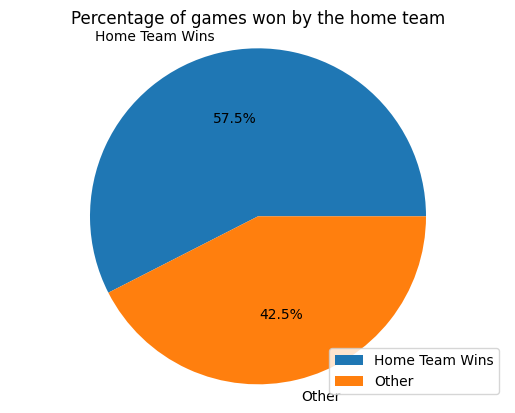

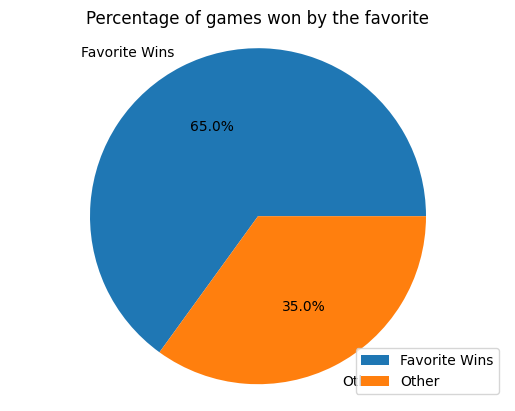

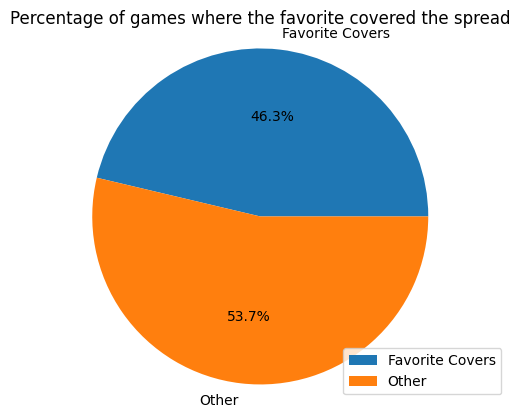

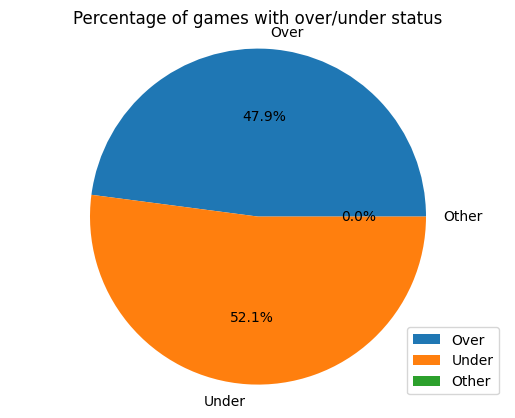

In [249]:
# Calculate the percentage of games won by the home team
home_win_percent = (df[df['winning_team'] == df['team_home']].shape[0] / df.shape[0]) * 100

# Calculate the percentage of favorites winning
favorite_win_percent = (df[df['winning_team'] == df['favorite_team']].shape[0] / df.shape[0]) * 100

# Calculate the percentage of games where the favorite covered the spread
favorite_cover_percent = (df[df['did_favorite_cover_spread'] == 'Yes'].shape[0] / df.shape[0]) * 100

# Calculate the percentage of games with over or under status
over_percent = (df[df['over_under_status'] == 'Over'].shape[0] / df.shape[0]) * 100

# Calculate the total number of games
total_games = df.shape[0]

# Display the results
print("Total number of games: {}".format(total_games))
print("Percentage of games won by the home team: {:.2f}%".format(home_win_percent))
print("Percentage of games won by favorite: {:.2f}%".format(favorite_win_percent))
print("Percentage of games where the favorite covered the spread: {:.2f}%".format(favorite_cover_percent))
print("Percentage of games with over: {:.2f}%".format(over_percent))


# Create pie chart for home team wins
labels_home = ['Home Team Wins', 'Other']
sizes_home = [home_win_percent, 100 - home_win_percent]
plt.figure()
plt.pie(sizes_home, labels=labels_home, autopct='%1.1f%%')
plt.title('Percentage of games won by the home team')
plt.axis('equal')
plt.legend(loc='lower right')

# Create pie chart for favorite team wins
labels_favorite = ['Favorite Wins', 'Other']
sizes_favorite = [favorite_win_percent, 100 - favorite_win_percent]
plt.figure()
plt.pie(sizes_favorite, labels=labels_favorite, autopct='%1.1f%%')
plt.title('Percentage of games won by the favorite')
plt.axis('equal')
plt.legend(loc='lower right')

# Create pie chart for favorite team covering the spread
labels_cover = ['Favorite Covers', 'Other']
sizes_cover = [favorite_cover_percent, 100 - favorite_cover_percent]
plt.figure()
plt.pie(sizes_cover, labels=labels_cover, autopct='%1.1f%%')
plt.title('Percentage of games where the favorite covered the spread')
plt.axis('equal')
plt.legend(loc='lower right')

# Create pie chart for over/under status
labels_over = ['Over', 'Under', 'Other']
sizes_over = [over_percent, 100 - over_percent, 0]  # Add 0 to represent 'Other' category with no percentage
plt.figure()
plt.pie(sizes_over, labels=labels_over, autopct='%1.1f%%')
plt.title('Percentage of games with over/under status')
plt.axis('equal')
plt.legend(loc='lower right')

# Display all the plots
plt.show()


Based on the information provided, we have a total of 11,031 games in our base dataframe, which provides us with the following insights:

- Percentage of games won by the favorite: 65.03%. This means that if we were to bet on the favorite in every game, we would have a 65% chance of making a correct prediction.

- Percentage of games where the favorite covered the spread: 46.98%. This indicates that if we were to bet on the favorite covering the spread in every game, we would have roughly a 47% chance of making a correct prediction.

- Percentage of games with the over: 48.37%. If we were to bet on the over in every game, we would have roughly a 48% chance of making a correct prediction.

These baseline values provide us with an understanding of the historical performance associated with betting on the favorite, covering the spread, and selecting the over. They will serve as a benchmark to evaluate the effectiveness of my subsequent analysis and models.

In [258]:
# Select the int and float columns
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate summary statistics for each column
summary_stats = numeric_columns.describe()

# Transpose the summary statistics DataFrame
transposed_stats = summary_stats.transpose()

# Print the summary statistics
print(transposed_stats)


                       count         mean        std     min     25%     50%  \
schedule_season      11031.0  2001.510108  12.561698  1979.0  1991.0  2002.0   
schedule_week        11031.0     9.537213   5.336445     1.0     5.0    10.0   
score_home           11031.0    22.754601  10.351172     0.0    16.0    23.0   
score_away           11031.0    20.097815  10.069313     0.0    13.0    20.0   
spread_favorite      11031.0     5.381153   3.435195     0.0     3.0     4.5   
over_under_line      10969.0    42.264628   4.806352    28.0    38.5    42.0   
weather_temperature  10054.0    60.034812  15.421025    -6.0    50.0    64.0   
weather_wind_mph     10038.0     7.131401   5.764600     0.0     0.0     7.0   
year                 11031.0  2001.570574  12.582820  1979.0  1991.0  2002.0   
fog_or_haze           9410.0     0.031350   0.174270     0.0     0.0     0.0   
month                11031.0     9.982685   2.514251     1.0     9.0    10.0   
day                  11031.0    15.58208

After analyzing the numeric columns, it appears that the most viable information for this analysis includes the following columns: spread_favorite, over_under_line, weather_temperature, and weather_wind_mph. This is to be expected since they are not date strings. The score columns will need to be removed to prevent bias and skewing the accuracy of our models.

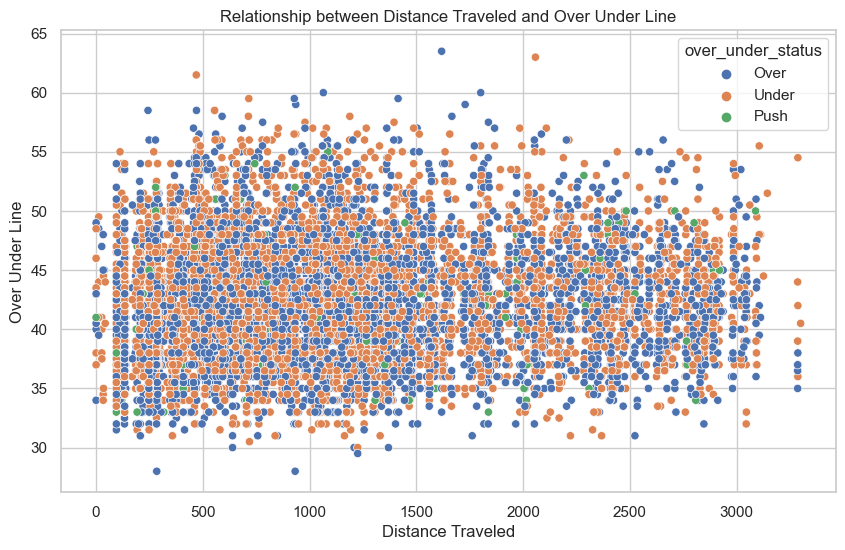

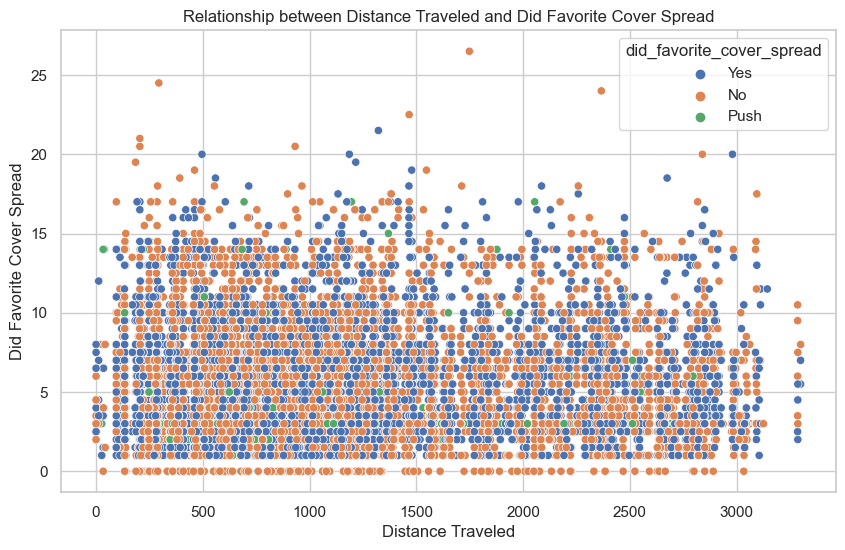

In [275]:
# Copy dataframe
data = df.copy()

# Fill missing values in distance_traveled with mean value
data['distance_traveled'].fillna(data['distance_traveled'].mean(), inplace=True)

# Data visualization - Scatter plot of distance traveled and over_under_line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='distance_traveled', y='over_under_line', hue='over_under_status')
plt.xlabel('Distance Traveled')
plt.ylabel('Over Under Line')
plt.title('Relationship between Distance Traveled and Over Under Line')
plt.show()

# Data visualization - Scatter plot of distance traveled and did_favorite_cover_spread
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='distance_traveled', y='spread_favorite', hue='did_favorite_cover_spread')
plt.xlabel('Distance Traveled')
plt.ylabel('Did Favorite Cover Spread')
plt.title('Relationship between Distance Traveled and Did Favorite Cover Spread')
plt.show()


The scatterplots presented above depict the relationship between distance traveled and the gambling outcomes. However, based on the visualizations, it is evident that further data mining is necessary to determine if distance traveled indeed has a significant impact.

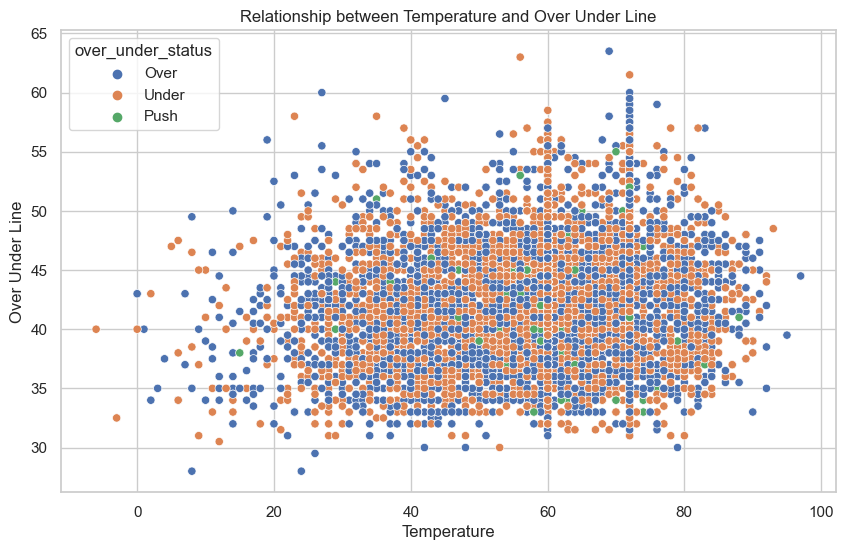

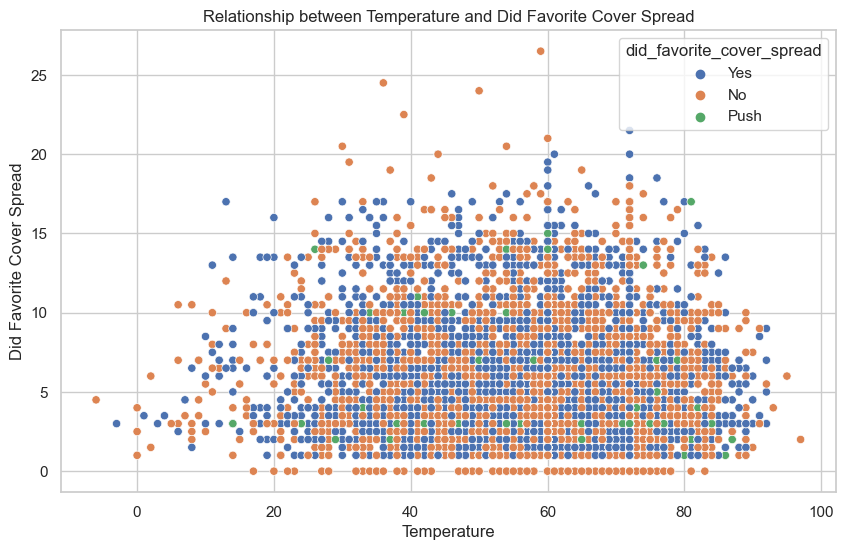

In [276]:
# Copy dataframe
data = df.copy()

# Fill missing values in weather_temperature with mean value
data['weather_temperature'].fillna(data['weather_temperature'].mean(), inplace=True)

# Data visualization - Scatter plot of temperature and over_under_line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='weather_temperature', y='over_under_line', hue='over_under_status')
plt.xlabel('Temperature')
plt.ylabel('Over Under Line')
plt.title('Relationship between Temperature and Over Under Line')
plt.show()

# Data visualization - Scatter plot of temperature and did_favorite_cover_spread
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='weather_temperature', y='spread_favorite', hue='did_favorite_cover_spread')
plt.xlabel('Temperature')
plt.ylabel('Did Favorite Cover Spread')
plt.title('Relationship between Temperature and Did Favorite Cover Spread')
plt.show()

Once again, we see a lot of overlap and no clear distinction in the results when comparing temperature to the game outcomes. This suggests that temperature alone may not be a strong predictor of game outcomes in this dataset.

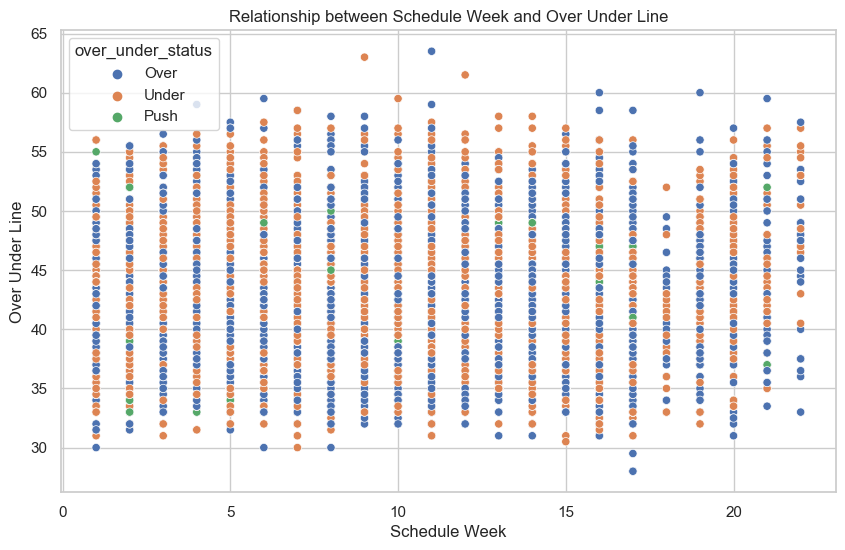

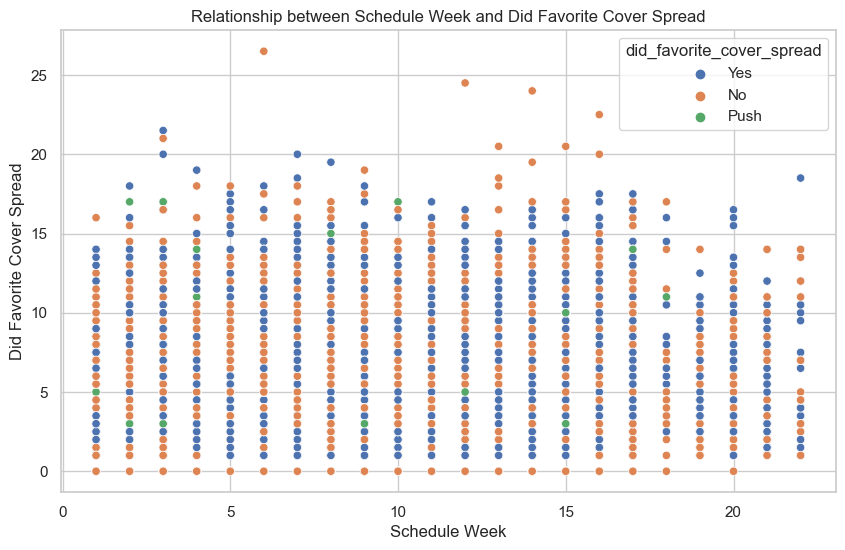

In [277]:
# Copy dataframe
data = df.copy()

# Fill missing values in schedule_week with mean value. There should be none
data['schedule_week'].fillna(data['schedule_week'].mean(), inplace=True)

# Data visualization - Scatter plot of schedule_week and over_under_line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='schedule_week', y='over_under_line', hue='over_under_status')
plt.xlabel('Schedule Week')
plt.ylabel('Over Under Line')
plt.title('Relationship between Schedule Week and Over Under Line')
plt.show()

# Data visualization - Scatter plot of schedule_week and did_favorite_cover_spread
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='schedule_week', y='spread_favorite', hue='did_favorite_cover_spread')
plt.xlabel('Schedule Week')
plt.ylabel('Did Favorite Cover Spread')
plt.title('Relationship between Schedule Week and Did Favorite Cover Spread')
plt.show()

In [287]:
# Calculate percentage of over_under_status for each schedule week
percentage_by_week = df.groupby('schedule_week')['over_under_status'].value_counts(normalize=True) * 100

# Print the percentage for each schedule week
for week, percentage in percentage_by_week.items():
    print(f'Schedule Week {week[0]} - Over Under Status: {week[1]}, Percentage: {percentage:.2f}%')


Schedule Week 1 - Over Under Status: Under, Percentage: 50.68%
Schedule Week 1 - Over Under Status: Over, Percentage: 47.37%
Schedule Week 1 - Over Under Status: Push, Percentage: 1.95%
Schedule Week 2 - Over Under Status: Under, Percentage: 52.79%
Schedule Week 2 - Over Under Status: Over, Percentage: 44.04%
Schedule Week 2 - Over Under Status: Push, Percentage: 3.17%
Schedule Week 3 - Over Under Status: Under, Percentage: 50.33%
Schedule Week 3 - Over Under Status: Over, Percentage: 48.21%
Schedule Week 3 - Over Under Status: Push, Percentage: 1.47%
Schedule Week 4 - Over Under Status: Over, Percentage: 49.32%
Schedule Week 4 - Over Under Status: Under, Percentage: 48.14%
Schedule Week 4 - Over Under Status: Push, Percentage: 2.54%
Schedule Week 5 - Over Under Status: Over, Percentage: 51.47%
Schedule Week 5 - Over Under Status: Under, Percentage: 47.83%
Schedule Week 5 - Over Under Status: Push, Percentage: 0.69%
Schedule Week 6 - Over Under Status: Under, Percentage: 52.10%
Schedul

It seems that there is no clear pattern or trend in the distribution of over_under_status and spread_favorite values across different schedule weeks. Further analysis and exploration may be needed to uncover any meaningful insights.

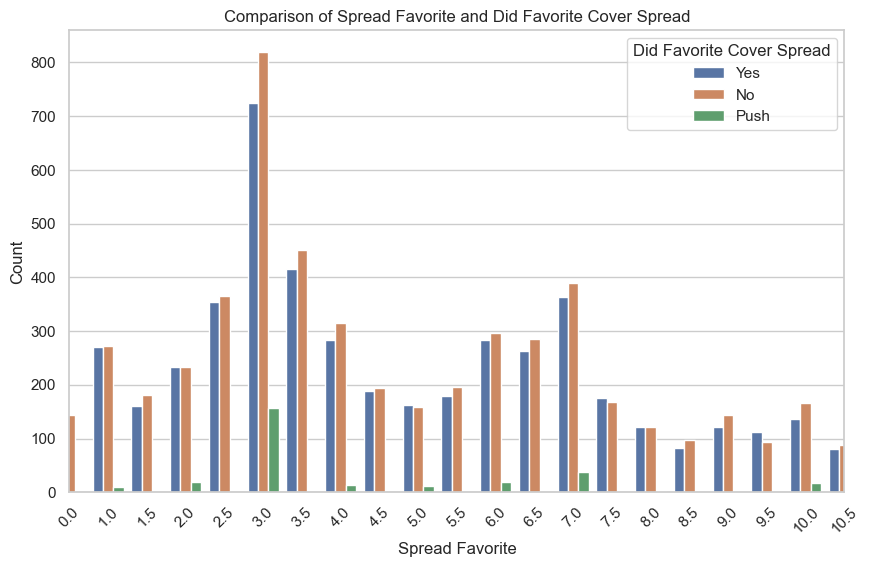

In [285]:
# Create a bar plot with limited x-axis range
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='spread_favorite', hue='did_favorite_cover_spread')
plt.xlabel('Spread Favorite')
plt.ylabel('Count')
plt.title('Comparison of Spread Favorite and Did Favorite Cover Spread')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend(title='Did Favorite Cover Spread', loc='upper right')
plt.xlim(0, 20.0)  # Set x-axis range from 0 to 15.0
plt.show()



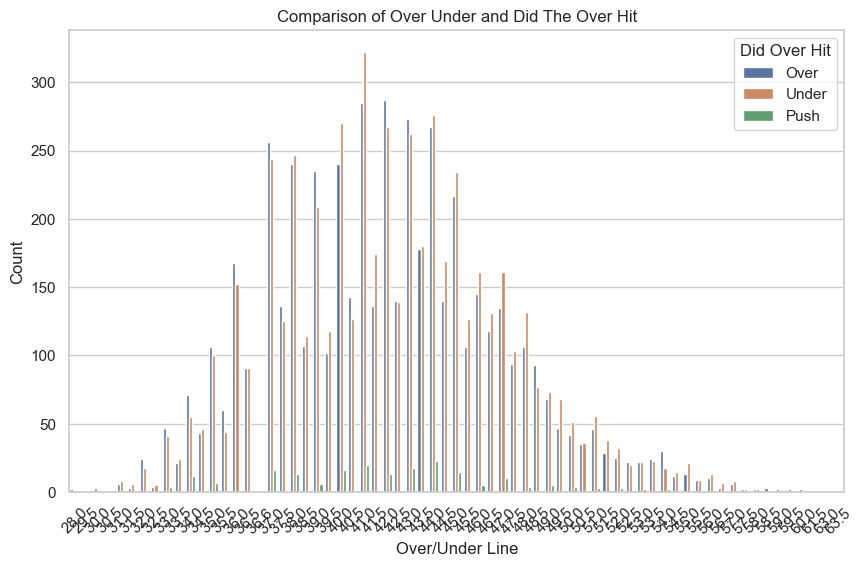

In [289]:
# Create a bar plot with limited x-axis range
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='over_under_line', hue='over_under_status')
plt.xlabel('Over/Under Line')
plt.ylabel('Count')
plt.title('Comparison of Over Under and Did The Over Hit')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.legend(title='Did Over Hit', loc='upper right')
plt.show()

The distribution of over_under_status and spread_favorite values does not show any clear Gaussian curve, and the break out seems to be even among the different result categories. This indicates that there may not be a strong relationship between these variables and the game outcomes. Further analysis and exploration are recommended to gain more insights.

In [46]:
# Calculate the number of wins as favorite for each team
favorite_wins = df[df['winning_team'] == df['favorite_team']].groupby('favorite_team').size()

# Calculate the total number of games as favorite for each team
total_favorite_games = df[df['favorite_team'].notnull()].groupby('favorite_team').size()

# Calculate the percentage of wins when favored for each team
win_percentage_favorite = (favorite_wins / total_favorite_games) * 100

# Get the top 5 teams with the most wins as favorites
top_5_favorite_wins = win_percentage_favorite.nlargest(5)

# Print the top 5 teams and their win percentage when favored
for team, win_percentage in top_5_favorite_wins.items():
    print(f"{team}: {win_percentage:.2f}%")


San Francisco 49ers: 72.89%
Indianapolis Colts: 72.59%
Baltimore Ravens: 72.45%
New England Patriots: 72.34%
Green Bay Packers: 71.67%


In [47]:
# Calculate the number of times the favorite covered the spread for each team
favorite_covered = df[df['did_favorite_cover_spread'] == 'Yes'].groupby('favorite_team').size()

# Calculate the total number of games where the favorite covered the spread for each team
total_favorite_covered = df[df['favorite_team'].notnull() & (df['did_favorite_cover_spread'].notnull())].groupby('favorite_team').size()

# Calculate the percentage of covering the spread when favored for each team
cover_percentage_favorite = (favorite_covered / total_favorite_covered) * 100

# Get the top 5 teams that cover the spread
top_5_covered_teams = cover_percentage_favorite.nlargest(5)

# Print the top 5 teams and their coverage percentage when favored
for team, cover_percentage in top_5_covered_teams.items():
    print(f"{team}: {cover_percentage:.2f}%")


Phoenix Cardinals: 54.17%
St. Louis Cardinals: 52.50%
San Francisco 49ers: 52.11%
Green Bay Packers: 51.27%
Buffalo Bills: 49.64%


In [77]:
# Calculate the number of games where the over was hit for each combination of home and away teams
over_hit_count = df[df['over_under_status'] == 'Over'].groupby(['team_home', 'team_away']).size()

# Get the top 5 combinations with the highest hit counts
top_5_over_combinations = over_hit_count.nlargest(5)

# Calculate the total number of games for each combination of home and away teams
total_games_count = df.groupby(['team_home', 'team_away']).size()

# Print the top 5 combinations, their hit counts, and the percentage of the total they hit the over
for combination, hit_count in top_5_over_combinations.items():
    hit_percentage = (hit_count / total_games_count[combination]) * 100
    print(f"{combination[0]} vs {combination[1]}: {hit_count} games ({hit_percentage:.2f}% of {total_games_count[combination]} games)")


Detroit Lions vs Green Bay Packers: 24 games (63.16% of 38 games)
New York Jets vs Buffalo Bills: 22 games (59.46% of 37 games)
Green Bay Packers vs Detroit Lions: 21 games (56.76% of 37 games)
Chicago Bears vs Green Bay Packers: 20 games (54.05% of 37 games)
Cincinnati Bengals vs Pittsburgh Steelers: 20 games (52.63% of 38 games)


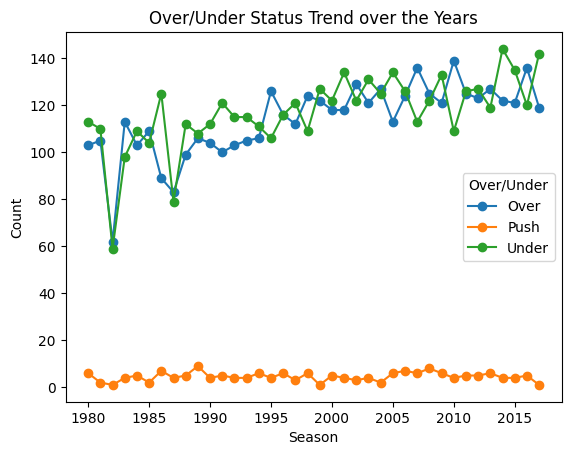

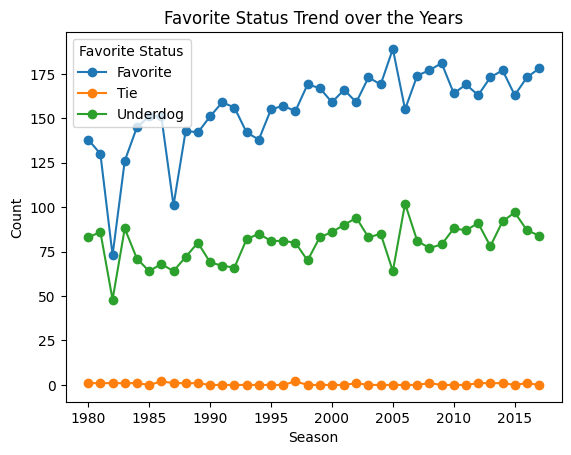

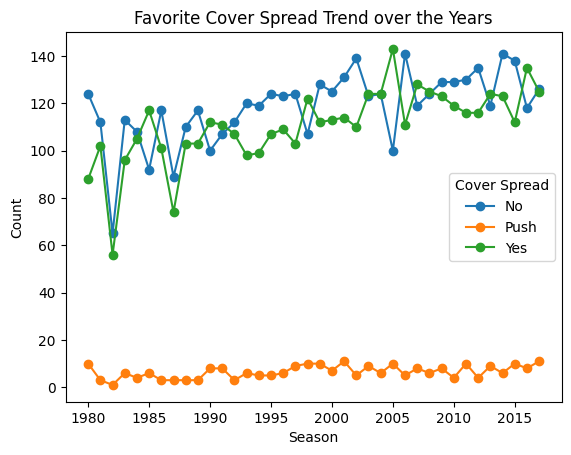

In [78]:
# Group the data by 'schedule_season' and calculate the value counts for each column
over_under_counts = df['over_under_status'].groupby(df['schedule_season']).value_counts().unstack(fill_value=0)
favorite_status_counts = df['favorite_status'].groupby(df['schedule_season']).value_counts().unstack(fill_value=0)
favorite_cover_counts = df['did_favorite_cover_spread'].groupby(df['schedule_season']).value_counts().unstack(fill_value=0)

# Plot trend graphs for 'over_under_status'
over_under_counts.plot(kind='line', marker='o')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Over/Under Status Trend over the Years')
plt.legend(title='Over/Under')
plt.show()

# Plot trend graphs for 'favorite_status'
favorite_status_counts.plot(kind='line', marker='o')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Favorite Status Trend over the Years')
plt.legend(title='Favorite Status')
plt.show()

# Plot trend graphs for 'did_favorite_cover_spread'
favorite_cover_counts.plot(kind='line', marker='o')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Favorite Cover Spread Trend over the Years')
plt.legend(title='Cover Spread')
plt.show()


Here are some key takeaways from the above graphs:

Some of the top-performing gambling teams are no longer in existence. Since this information is historical and not relevant to the current analysis, it will not provide valuable insights.

The trends in gambling results over the years do not exhibit a clear pattern. Some years show higher frequencies of certain gambling outcomes than others. It is worth considering tracking the games or weeks into the season to identify if there is a correlation between the schedule year and specific gambling outcomes for further investigation.

In conclusion, the initial data analysis provided baseline results for comparison with future models. The analysis involved comparing various features to gambling outcomes in order to identify apparent correlations. However, the results indicate that the data set contains a significant amount of overlap and lacks clear patterns or distinct relationships. This suggests that achieving significant improvements beyond the baseline results may be challenging. Further exploration and advanced techniques will be used to uncover any hidden patterns or factors that can enhance the predictive power of the models.

### Continued Data Preperation and Feature Creation

After careful consideration and taking into account the potential feature explosion resulting from categorical encoding of home and away teams as well as stadium names, I have decided to work with a smaller subset of features that may capture a meaningful signal. The goal here is to reduce feature overlap and initiate the process of feature reduction. When there is a significant amount of overlap among features, it can be challenging for models to identify clear signals or patterns.

To start, I will assign home and away divisions and conferences to further differentiate the teams. This will provide additional information that could potentially contribute to better predictions and model performance.

In [16]:
# Read the team data file into a data frame
teams = pd.read_csv('/Users/jonwoodland/school/Harvard/Data_Mining_E-108/CSCI-E-108_my_venv/project_data/archive/nfl_teams.csv')[['team_name', 'team_conference', 'team_division', 'team_division_pre2002']]


In [17]:
# Step 1: Identify null values in 'team_division' column
null_values = teams['team_division'].isnull()

# Step 2: Replace null values with non-null values from 'team_division_pre2002' column
teams.loc[null_values, 'team_division'] = teams.loc[null_values, 'team_division_pre2002']

# Step 3: Drop 'team_division_pre2002' column
teams = teams.drop('team_division_pre2002', axis=1)

In [18]:
# Merge the two dataframes on the 'df' and 'teams' columns using a left join
merged_df = pd.merge(df, teams, left_on='team_home', right_on='team_name', how='left')

In [19]:
# Rename 'team_conference' to 'home_team_conference'
merged_df = merged_df.rename(columns={'team_conference': 'home_team_conference'})

# Rename 'team_division' to 'home_team_division'
merged_df = merged_df.rename(columns={'team_division': 'home_team_division'})

In [20]:
# Drop 'team_name' column
merged_df = merged_df.drop('team_name', axis=1)

In [21]:
# Do the same for away team 

# Merge the two dataframes on the 'df' and 'teams' columns using a left join
df = pd.merge(merged_df, teams, left_on='team_away', right_on='team_name', how='left')

# Rename 'team_conference' to 'away_team_conference'
df = df.rename(columns={'team_conference': 'away_team_conference'})

# Rename 'team_division' to 'away_team_division'
df = df.rename(columns={'team_division': 'away_team_division'})

# Drop 'team_name' column
df = df.drop('team_name', axis=1)

To incorporate regional information based on the home and away team states, we can assign a US region to each state. This approach aims to achieve two objectives:

1. Reduce the feature space by grouping states into broader regions.
2. Potentially capture any patterns or signals related to teams traveling across different regions.


In [23]:
# Map state abbreviation to region

def get_us_region(state):
    state_regions = {
        'AL': 'South',
        'AK': 'West',
        'AZ': 'West',
        'AR': 'South',
        'CA': 'West',
        'CO': 'West',
        'CT': 'Northeast',
        'DE': 'Northeast',
        'FL': 'South',
        'GA': 'South',
        'HI': 'West',
        'ID': 'West',
        'IL': 'Midwest',
        'IN': 'Midwest',
        'IA': 'Midwest',
        'KS': 'Midwest',
        'KY': 'South',
        'LA': 'South',
        'ME': 'Northeast',
        'MD': 'Northeast',
        'MA': 'Northeast',
        'MI': 'Midwest',
        'MN': 'Midwest',
        'MS': 'South',
        'MO': 'Midwest',
        'MT': 'West',
        'NE': 'Midwest',
        'NV': 'West',
        'NH': 'Northeast',
        'NJ': 'Northeast',
        'NM': 'West',
        'NY': 'Northeast',
        'NC': 'South',
        'ND': 'Midwest',
        'OH': 'Midwest',
        'OK': 'South',
        'OR': 'West',
        'PA': 'Northeast',
        'RI': 'Northeast',
        'SC': 'South',
        'SD': 'Midwest',
        'TN': 'South',
        'TX': 'South',
        'UT': 'West',
        'VT': 'Northeast',
        'VA': 'South',
        'WA': 'West',
        'WV': 'South',
        'WI': 'Midwest',
        'WY': 'West',
    }

    region = state_regions.get(state)
    
    if region:
        return region
    else:
        return "Unknown"


In [22]:
# Split 'team_location' column into 'city' and 'state' columns
df[['city', 'home_team_state']] = df['team_location'].str.split(", ", expand=True)

# Drop the 'city' column
df.drop('city', axis=1, inplace=True)

In [24]:
# Go through df and assign region to home team
df['home_team_us_region'] = df['home_team_state'].apply(get_us_region)

In [25]:
# Split 'away_team_address' column into 'city' and 'state' columns
df[['city', 'away_team_state']] = df['away_team_address'].str.split(", ", expand=True)

# Drop the 'city' column
df.drop('city', axis=1, inplace=True)

In [26]:
# Go through df and assign region to away team
df['away_team_us_region'] = df['away_team_state'].apply(get_us_region)

Now we will proceed to drop more unnecessary columns that contain the outcomes of the game. These could potentially introduce bias and falsely inflate the accuracy of the models. By removing these columns, we can ensure a more objective evaluation of the model's performance.

In [29]:
columns_to_drop = ['team_home', 'team_away', 'team_favorite_id', 'stadium', 'stadium_location',
                   'favorite_team', 'winning_team', 'team_location', 'away_team_address',
                   'home_team_state', 'away_team_state']

df.drop(columns_to_drop, axis=1, inplace=True)

In [30]:
print_distinct_values(df)


schedule_season
[1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022]

schedule_week
[ 1  3  6  7  8 10 12 14  5 13 15 20  4  9 16  2 11 21 22 19 17 18]

schedule_playoff
[False  True]

score_home
[31 24 17 35 14 44  7 12 33 13 28 30 10 34  6 27 25 21 19 38 51 42 37 50
 32 23 20 26 22 16 29 45  0  3  9 56 46 39 43 48 59 47 40 41 36 61 11 15
 18 55 52  5 62  8 49 54 58 57  2 53]

score_away
[16 10 17  7  9 27  3 13 24 28 14 21 12 18  0 31 19 42 22 20 40 23 15 25
 38 30 33 26 35 36 29 51  6 34 37  8 45 41 39  2 32 52 44 43 55 11 48 47
 50  5 49 46 56 54 59]

spread_favorite
[ 3.   6.  13.   4.   7.   8.   5.   1.   0.   9.5 11.   9.  10.  14.
 12.   2.  10.5  8.5  3.5  6.5  4.5 15.   2.5  7.5  5.5 13.5  1.5 12.5
 14.5 15.5 11.5 17.  19.5 16.  17.5 20.  18.  19.  16.5 24.  18.5 24.5
 22.5 20.5 26.5 21.5 21. ]

over_unde

Next, we will proceed to categorical encode the string columns in our dataset. The reason for this encoding is that most machine learning algorithms require numerical input, and categorical data in its raw form cannot be directly processed by these algorithms. By converting categorical variables into numerical representations, we enable the algorithms to perform mathematical computations and extract patterns from the data (Towards Data).

Categorical encoding transforms each category or label into a numerical value, allowing the algorithm to understand the relationship between different categories. There are various methods for categorical encoding, such as one-hot encoding, label encoding, and ordinal encoding, depending on the nature of the categorical variables and the requirements of the analysis.

For this project we will be using dummy encoding.

In [31]:
# Define the list of categorical columns to encode
categorical_cols = ['stadium_surface','stadium_type', 'stadium_weather_type','sky','precipitation','home_team_conference','home_team_division','away_team_conference','away_team_division','home_team_us_region','away_team_us_region']

# Use pandas get_dummies function to dummy encode the categorical columns
df = pd.get_dummies(df, columns=categorical_cols)

In [32]:
# Create a list of boolean columns to encode
bool_cols = ['schedule_playoff', 'stadium_neutral']

# Loop through the list of boolean columns and encode each one
for col in bool_cols:
    # Create a new column with the suffix '_encoded' and map False to 0 and True to 1
    df[col + '_encoded'] = df[col].map({False: 0, True: 1})
    
    # Drop the original boolean column from the DataFrame
    df.drop(col, axis=1, inplace=True)

In [33]:
df.shape

(11031, 69)

After encoding we are left with 69 columns of data and still 11,031 games.

In [34]:
# Cast stadium capacity to float by removing string comma
df['stadium_capacity'] = df['stadium_capacity'].str.replace(',', '').astype(float)

Similar to the categorical encoding performed earlier, we will now convert the target columns to binary format. Binary encoding is a memory-efficient encoding scheme that uses fewer features compared to methods like one-hot encoding. This is beneficial for data with high cardinality as it helps reduce the curse of dimensionality, as mentioned in (Analytics Vidha).

By converting the target columns to binary format, we represent each unique category as a binary sequence, which efficiently captures the information without expanding the feature space excessively.

In [35]:
# Encode favorite_status as binary variable
df['did_favorite_win'] = df['favorite_status'].apply(lambda x: 1 if x == 'Favorite' else 0)

# Drop the original favorite_status column
df.drop('favorite_status', axis=1, inplace=True)

# Assign a value of 1 to rows where did_favorite_cover_spread is 'Yes' and 0 otherwise
df['covered'] = df['did_favorite_cover_spread'].apply(lambda x: 1 if x == 'Yes' else 0)

# Remove the did_favorite_cover_spread column from the DataFrame along the axis 1 (columns)
df.drop('did_favorite_cover_spread', axis=1, inplace=True)

# Assign a value of 1 to rows where over_under_status is 'Over' and 0 otherwise
df['did_over_hit'] = df['over_under_status'].apply(lambda x: 1 if x == 'Over' else 0)

# Remove the over_under_status column from the DataFrame along the axis 1 (columns)
df.drop('over_under_status', axis=1, inplace=True)

In [36]:
# Forgot to drop these before
df.drop('score_home', axis=1, inplace=True)
df.drop('score_away', axis=1, inplace=True)

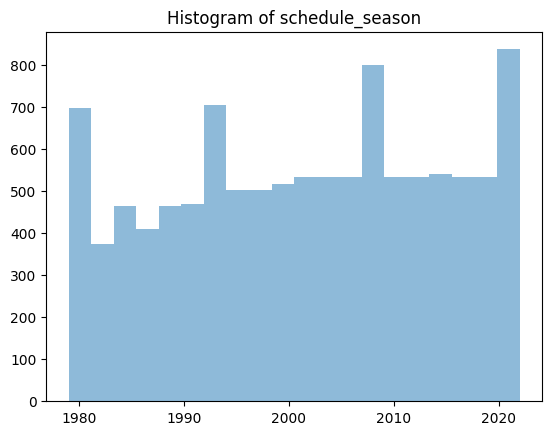

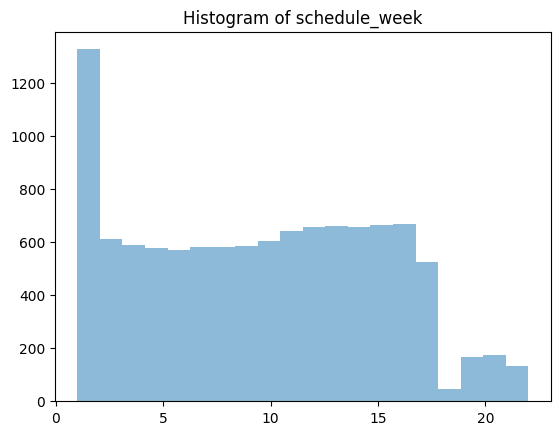

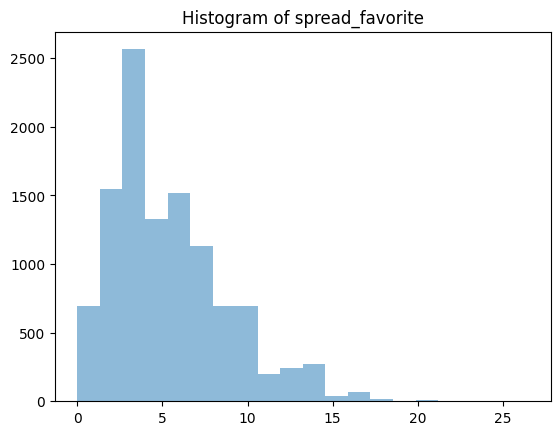

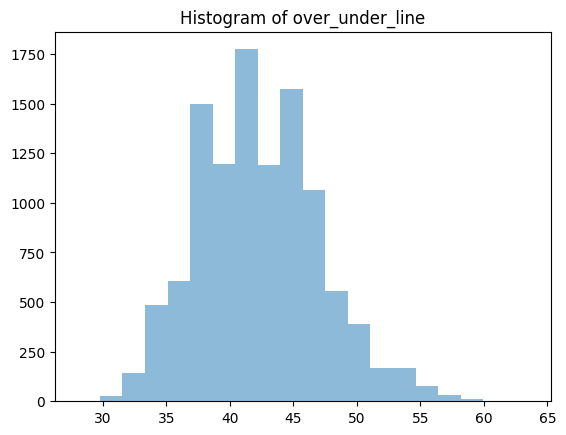

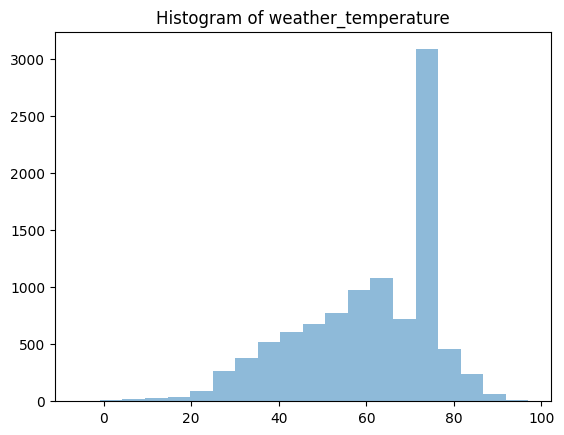

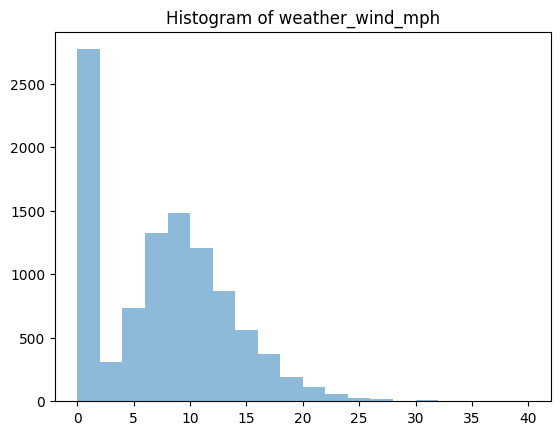

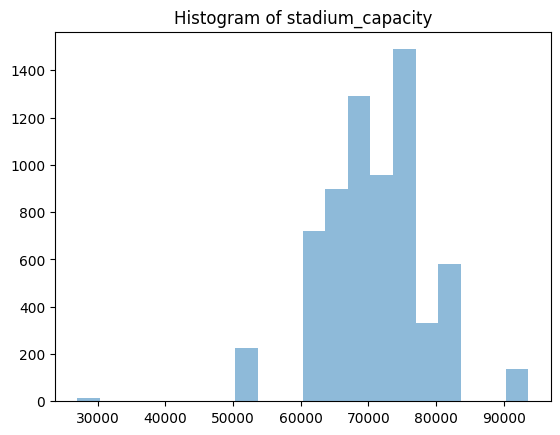

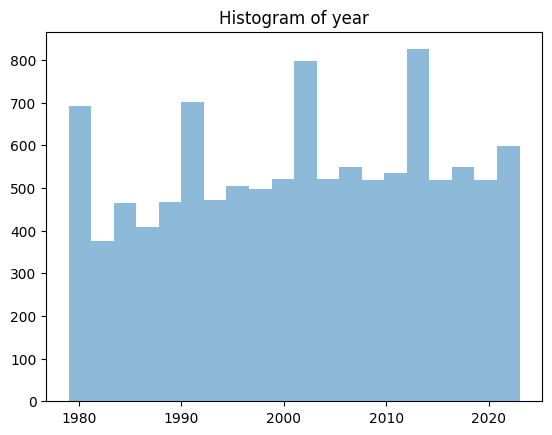

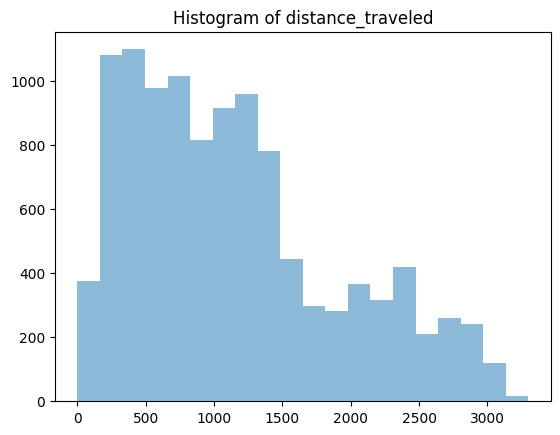

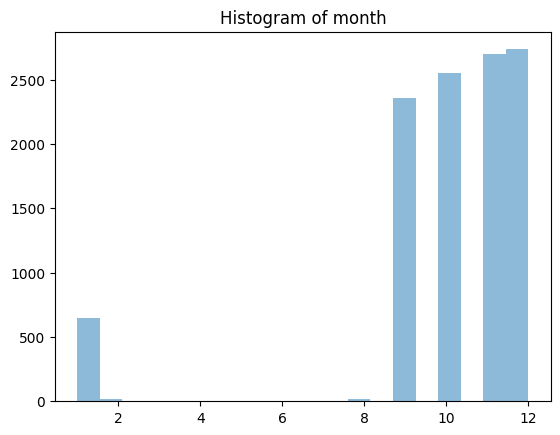

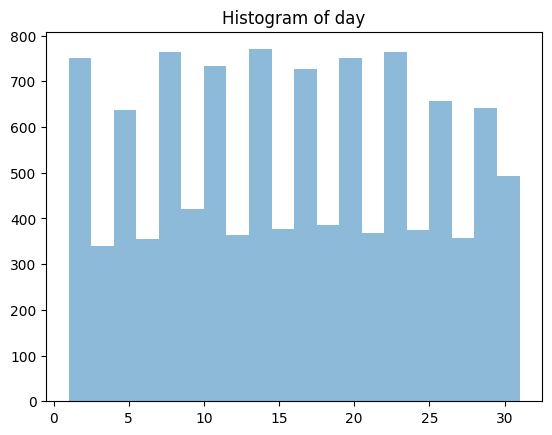

In [39]:
# Create histogram of columns to see the spread of data we have in each column but skipping binary columns
for col in df.columns:
    if df[col].dtype == bool or df[col].nunique() <= 2:
        continue
    plt.hist(df.loc[:, col].dropna(), bins=20, alpha=0.5)  # Exclude NaN values using dropna()
    plt.title('Histogram of ' + col)
    plt.show()


In [42]:
print(df.columns)
print(df.dtypes)

Index(['schedule_season', 'schedule_week', 'spread_favorite',
       'over_under_line', 'weather_temperature', 'weather_wind_mph',
       'stadium_capacity', 'year', 'distance_traveled', 'fog_or_haze', 'month',
       'day', 'stadium_surface_FieldTurf', 'stadium_surface_Grass',
       'stadium_surface_Hellas Matrix Turf', 'stadium_type_indoor',
       'stadium_type_outdoor', 'stadium_type_retractable',
       'stadium_weather_type_cold', 'stadium_weather_type_dome',
       'stadium_weather_type_moderate', 'stadium_weather_type_warm',
       'sky_clear', 'sky_clear/cloudy mix', 'sky_overcast/mostly cloudy',
       'precipitation_None', 'precipitation_light rain',
       'precipitation_light snow', 'precipitation_rain/storm',
       'precipitation_snow', 'home_team_conference_AFC',
       'home_team_conference_NFC', 'home_team_division_AFC Central',
       'home_team_division_AFC East', 'home_team_division_AFC North',
       'home_team_division_AFC South', 'home_team_division_AFC West',


We will now use the describe() function on the dataframe to obtain a summary of the columns. This will help us identify any non-numeric or unencoded columns.

In [43]:
# Select the int and float columns
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate summary statistics for each column
summary_stats = numeric_columns.describe()

# Transpose the summary statistics DataFrame
transposed_stats = summary_stats.transpose()

# Print the summary statistics
print(transposed_stats)

                            count          mean          std      min  \
schedule_season           11031.0   2001.510108    12.561698   1979.0   
schedule_week             11031.0      9.537213     5.336445      1.0   
spread_favorite           11031.0      5.381153     3.435195      0.0   
over_under_line           10969.0     42.264628     4.806352     28.0   
weather_temperature       10054.0     60.034812    15.421025     -6.0   
weather_wind_mph          10038.0      7.131401     5.764600      0.0   
stadium_capacity           6645.0  70925.694357  7549.659104  27000.0   
year                      11031.0   2001.570574    12.582820   1979.0   
distance_traveled         10982.0   1150.144946   762.515959      0.0   
fog_or_haze                9410.0      0.031350     0.174270      0.0   
month                     11031.0      9.982685     2.514251      1.0   
day                       11031.0     15.582087     8.638459      1.0   
schedule_playoff_encoded  11031.0      0.042970    

The weather temperature and distance traveled stand out as having potentially high standard deviations. As described in Wikipedia's definition of standard deviation, "In statistics, the standard deviation is a measure of the amount of variation or dispersion of a set of values. A low standard deviation indicates that the values tend to be close to the mean (also called the expected value) of the set, while a high standard deviation indicates that the values are spread out over a wider range." (Standard Deviation)

## Feature Selection
We will now start the process of feature selection. We will explore three statistical-based methods: Chi-2, Pearson, and T-test. Additionally, we will conduct False Discovery Rate (FDR) methods using Bonferroni and Benjamini-Hochberg (BH) adjustments when applicable. The goal of feature selection is to identify a subset of relevant features to use in model construction. (Feature Selection)

Let's begin with Chi-2 feature selection. The main concept behind Chi-2 is to compare the observed value count with the expected outcome count and assess the deviation between the two. This helps in determining the relevance of features. (Chi-2)

In [50]:
def feature_selection_chi2(df, target_col, exclude_columns=[], k=5):
    """
    Perform feature selection using the chi-squared test.

    Args:
        df (DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        k (int): The number of top features to select.

    Returns:
        significant_features (DataFrame): The significant features without FDR correction.
        bh_significant_features (DataFrame): The significant features after Benjamini-Hochberg FDR correction.
        bonferroni_significant_features (DataFrame): The significant features after Bonferroni FDR correction.
    """

    # Create a new series containing the target variable
    y = df[target_col]

    # Create a new dataframe containing only the features to be tested
    X = df.drop(exclude_columns, axis=1)

    # Drop rows with missing values
    X.dropna(inplace=True)
    y = y[X.index]

    # Scale the feature values to a range of [0, 1]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply SelectKBest to identify the top k features
    k = k
    best_features = SelectKBest(score_func=chi2, k=k)
    fit = best_features.fit(X_scaled, y)

    # Create a dataframe with the top k features and their scores
    scores = pd.DataFrame(fit.scores_)
    columns = pd.DataFrame(X.columns)
    p_values = pd.DataFrame(fit.pvalues_)
    feature_scores = pd.concat([columns, scores, p_values], axis=1)
    feature_scores.columns = ['Feature', 'Score', 'P-value']
    
    # Filter the features that have a significant chi-squared score
    significant_features = feature_scores[feature_scores['P-value'] < 0.05]

    # Print the top k significant features and their scores
    print(f'Top {len(significant_features)} Significant Chi2 Features (No FDR):')
    print(f'{significant_features} \n')

    # Apply Benjamini-Hochberg and Bonferroni FDR correction methods
    bh_corrected = multipletests(significant_features['P-value'], alpha=0.05, method='fdr_bh')
    bonferroni_corrected = multipletests(significant_features['P-value'], alpha=0.05, method='bonferroni')

    # Filter the features that are significant after applying FDR correction methods
    bh_significant_features = significant_features[bh_corrected[0]]
    bonferroni_significant_features = significant_features[bonferroni_corrected[0]]

    # Print the top k significant features after applying FDR correction methods
    print(f'Top {len(bh_significant_features)} Significant Chi2 Features (Benjamini-Hochberg FDR):')
    print(f'{bh_significant_features} \n')
    print(f'Top {len(bonferroni_significant_features)} Significant Chi2 Features (Bonferroni FDR):')
    print(bonferroni_significant_features)

    # Return the top k significant feature names as a list
    return significant_features, bh_significant_features, bonferroni_significant_features


In [51]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit']
top_features_favorite_chi2 = feature_selection_chi2(df,'did_favorite_win', exclude_columns, 64)

Top 5 Significant Chi2 Features (No FDR):
                          Feature      Score   P-value
2                 spread_favorite  23.828368  0.000001
36    home_team_division_AFC West   5.909103  0.015063
48    away_team_division_NFC East   5.010427  0.025195
53  home_team_us_region_Northeast   4.083044  0.043316
58  away_team_us_region_Northeast   4.083044  0.043316 

Top 5 Significant Chi2 Features (Benjamini-Hochberg FDR):
                          Feature      Score   P-value
2                 spread_favorite  23.828368  0.000001
36    home_team_division_AFC West   5.909103  0.015063
48    away_team_division_NFC East   5.010427  0.025195
53  home_team_us_region_Northeast   4.083044  0.043316
58  away_team_us_region_Northeast   4.083044  0.043316 

Top 1 Significant Chi2 Features (Bonferroni FDR):
           Feature      Score   P-value
2  spread_favorite  23.828368  0.000001


In [52]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit']
top_features_covered_chi2 = feature_selection_chi2(df,'covered', exclude_columns, 64)

Top 1 Significant Chi2 Features (No FDR):
                        Feature     Score   P-value
51  away_team_division_NFC West  5.305891  0.021253 

Top 1 Significant Chi2 Features (Benjamini-Hochberg FDR):
                        Feature     Score   P-value
51  away_team_division_NFC West  5.305891  0.021253 

Top 1 Significant Chi2 Features (Bonferroni FDR):
                        Feature     Score   P-value
51  away_team_division_NFC West  5.305891  0.021253


In [53]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit']
top_features_over_chi2 = feature_selection_chi2(df,'did_over_hit', exclude_columns, 64)

Top 2 Significant Chi2 Features (No FDR):
                     Feature      Score   P-value
26  precipitation_light rain  11.285902  0.000781
62  schedule_playoff_encoded   5.504890  0.018963 

Top 2 Significant Chi2 Features (Benjamini-Hochberg FDR):
                     Feature      Score   P-value
26  precipitation_light rain  11.285902  0.000781
62  schedule_playoff_encoded   5.504890  0.018963 

Top 2 Significant Chi2 Features (Bonferroni FDR):
                     Feature      Score   P-value
26  precipitation_light rain  11.285902  0.000781
62  schedule_playoff_encoded   5.504890  0.018963


Upon analyzing the results, we observed that only a small subset of features in all three gambling outcomes had a p-value less than 0.05 when using the Chi-2 feature selection method. This indicates that Chi-2 may not be the most suitable method for our feature selection process.

Now we will use Pearson correlation to explore potential features. Pearson correlation measures the linear correlation between two sets of data. It is calculated as the ratio between the covariance of two variables and the product of their standard deviations, resulting in a value between -1 and 1 that indicates the strength and direction of the correlation (Pearson).

To begin, we will split the three gambling columns into separate dataframes and exclude the other gambling columns from each. Then, we will calculate the correlation coefficients using the Pearson correlation function. We will create a heat map to visualize the correlations, and finally, filter the results to identify the highest correlations between the target variable and the features.

In [54]:
# Create dataframe to focus on did the favorite win
exclude_columns=['covered', 'did_over_hit']
 
fav = df.drop(exclude_columns, axis=1)

fav.head()

schedule_season  schedule_week  spread_favorite  over_under_line  \
0             1979              1              3.0             30.0   
1             1979              3              6.0             42.0   
2             1979              6             13.0             40.0   
3             1979              7              4.0             36.0   
4             1979              8              7.0             42.0   

   weather_temperature  weather_wind_mph  stadium_capacity  year  \
0                 79.0               9.0               NaN  1979   
1                 65.0              10.0               NaN  1979   
2                 56.0              13.0               NaN  1979   
3                 41.0              10.0           80735.0  1979   
4                 72.0               0.0           76468.0  1979   

   distance_traveled  fog_or_haze  ...  home_team_us_region_Unknown  \
0             1208.0          NaN  ...                            0   
1              638.0          NaN  ...                            0   
2              714.0          NaN  ...                            0   
3              394.0          NaN  ...                            0   
4             1094.0          NaN  ...                            0   

   home_team_us_region_West  away_team_us_region_Midwest  \
0                         0                            1   
1                         0                            1   
2                         0                            1   
3                         0                            1   
4                         0                            1   

   away_team_us_region_Northeast  away_team_us_region_South  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   away_team_us_region_Unknown  away_team_us_region_West  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   schedule_playoff_encoded  stadium_neutral_encoded  did_favorite_win  
0                         0                        0                 1  
1                         0                        0                 1  
2                         0                        0                 1  
3                         0                        0                 1  
4                         0                        0                 1  

[5 rows x 65 columns]

In [55]:
fav_cor= fav.corr()
fav_cor

schedule_season  schedule_week  spread_favorite  \
schedule_season                     1.000000       0.018648         0.023063   
schedule_week                       0.018648       1.000000         0.083098   
spread_favorite                     0.023063       0.083098         1.000000   
over_under_line                     0.389558      -0.001151         0.051719   
weather_temperature                 0.103496      -0.454040        -0.060670   
...                                      ...            ...              ...   
away_team_us_region_Unknown        -0.116839       0.007222        -0.016642   
away_team_us_region_West           -0.021576      -0.015006        -0.013446   
schedule_playoff_encoded           -0.003694       0.416302         0.028154   
stadium_neutral_encoded             0.049420       0.082385         0.001537   
did_favorite_win                    0.021535       0.020433         0.237600   

                             over_under_line  weather_temperature  \
schedule_season                     0.389558             0.103496   
schedule_week                      -0.001151            -0.454040   
spread_favorite                     0.051719            -0.060670   
over_under_line                     1.000000             0.170461   
weather_temperature                 0.170461             1.000000   
...                                      ...                  ...   
away_team_us_region_Unknown        -0.033511            -0.017703   
away_team_us_region_West            0.040507             0.011841   
schedule_playoff_encoded            0.073625            -0.011663   
stadium_neutral_encoded             0.066309             0.037718   
did_favorite_win                    0.016430            -0.031275   

                             weather_wind_mph  stadium_capacity      year  \
schedule_season                     -0.280030         -0.130582  0.999822   
schedule_week                        0.018047         -0.006453  0.027175   
spread_favorite                      0.024668          0.015069  0.023763   
over_under_line                     -0.275517          0.025570  0.389829   
weather_temperature                 -0.428438         -0.088947  0.102343   
...                                       ...               ...       ...   
away_team_us_region_Unknown          0.050246         -0.007181 -0.116669   
away_team_us_region_West            -0.013448          0.037836 -0.021617   
schedule_playoff_encoded            -0.067199          0.017665  0.010287   
stadium_neutral_encoded             -0.027975         -0.005234  0.052222   
did_favorite_win                     0.004040          0.009443  0.021805   

                             distance_traveled  fog_or_haze  ...  \
schedule_season                      -0.051032    -0.086815  ...   
schedule_week                        -0.001362     0.049441  ...   
spread_favorite                       0.014199     0.003777  ...   
over_under_line                       0.040222    -0.010945  ...   
weather_temperature                   0.093853    -0.073121  ...   
...                                        ...          ...  ...   
away_team_us_region_Unknown          -0.017155     0.028264  ...   
away_team_us_region_West              0.375447    -0.008497  ...   
schedule_playoff_encoded              0.064464     0.034778  ...   
stadium_neutral_encoded               0.037908     0.000187  ...   
did_favorite_win                      0.003037    -0.005017  ...   

                             home_team_us_region_Unknown  \
schedule_season                                -0.116839   
schedule_week                                   0.007222   
spread_favorite                                -0.016642   
over_under_line                                -0.033511   
weather_temperature                            -0.017703   
...                                                  ...   
away_team_us_region_Unknown                     1.000000   
away_team_us_regi

<AxesSubplot: >

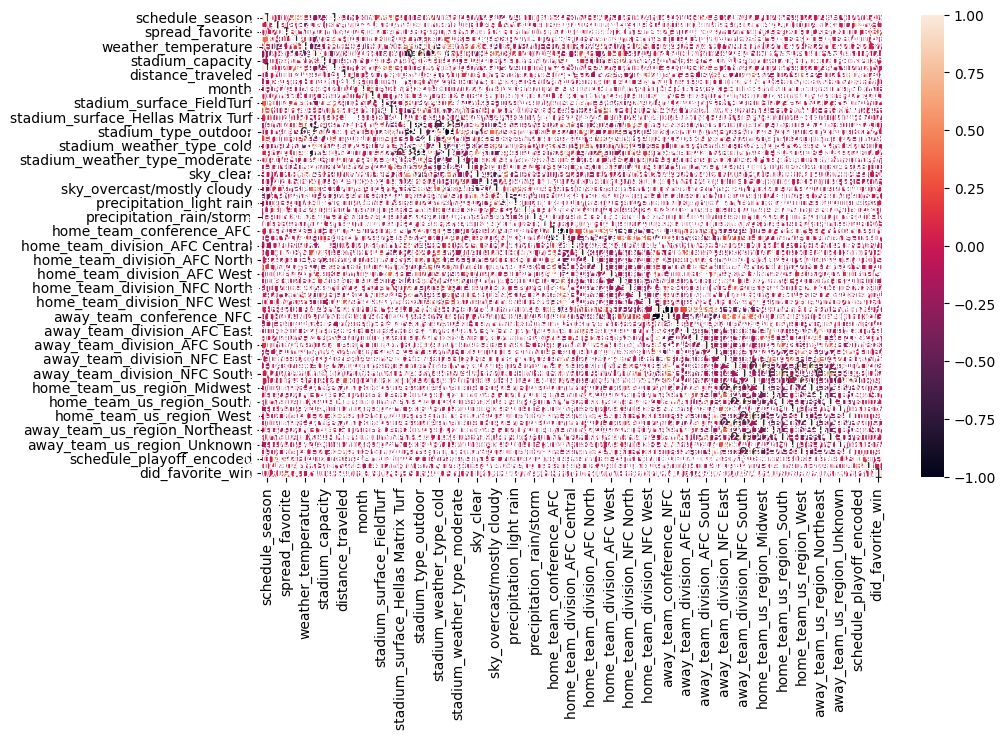

In [57]:
plt.figure(figsize=(10,6))
sns.heatmap(fav_cor, annot=True)

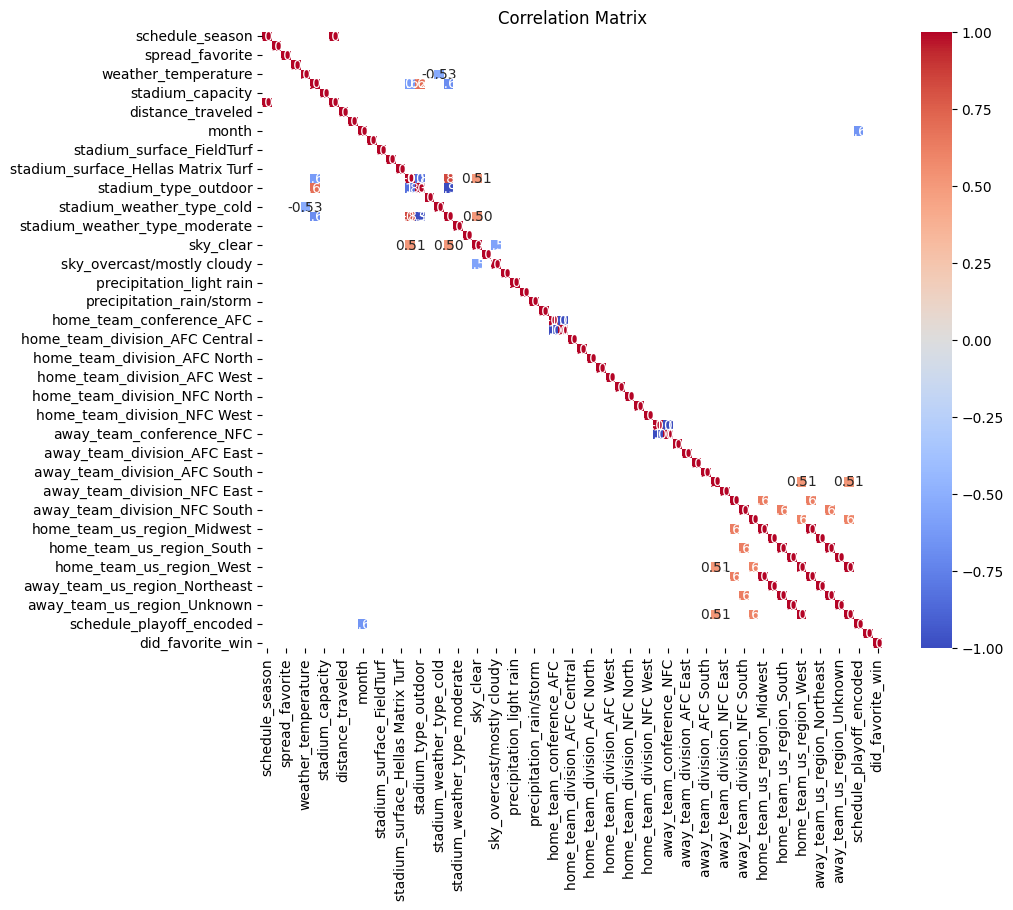

In [86]:
# Set a threshold
threshold = 0.5

# Mask correlations below the threshold
fav_cor_masked = fav_cor.mask(np.abs(fav_cor) <= threshold)

# Visualize the masked correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(fav_cor_masked, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

It is somewhat difficult to discern from the graph, but the correlation scores for 'did_favorite_win' do not seem to exhibit strong correlations with any of the features. To gain further insights, we will set a threshold for the alpha value and identify any scores that surpass this threshold.

In [64]:
threshold=0.05
a=abs(fav_cor['did_favorite_win'])
fav_sig_feat=a[a>threshold]
fav_sig_feat

spread_favorite     0.2376
did_favorite_win    1.0000
Name: did_favorite_win, dtype: float64

In [63]:
threshold=0.02
a=abs(fav_cor['did_favorite_win'])
fav_sig_feat=a[a>threshold]
fav_sig_feat

schedule_season                  0.021535
schedule_week                    0.020433
spread_favorite                  0.237600
weather_temperature              0.031275
year                             0.021805
stadium_surface_FieldTurf        0.029325
sky_clear/cloudy mix             0.022765
home_team_division_NFC South     0.020096
away_team_division_AFC West      0.020116
away_team_division_NFC East      0.023993
away_team_division_NFC West      0.024429
home_team_us_region_Midwest      0.027364
home_team_us_region_Northeast    0.035377
away_team_us_region_Midwest      0.027364
away_team_us_region_Northeast    0.035377
did_favorite_win                 1.000000
Name: did_favorite_win, dtype: float64

In [66]:
# Create dataframe to focus on did the spread cover
exclude_columns=['did_favorite_win', 'did_over_hit']
 
cov = df.drop(exclude_columns, axis=1)


In [67]:
cov_cor= cov.corr()
cov_cor

schedule_season  schedule_week  spread_favorite  \
schedule_season                     1.000000       0.018648         0.023063   
schedule_week                       0.018648       1.000000         0.083098   
spread_favorite                     0.023063       0.083098         1.000000   
over_under_line                     0.389558      -0.001151         0.051719   
weather_temperature                 0.103496      -0.454040        -0.060670   
...                                      ...            ...              ...   
away_team_us_region_Unknown        -0.116839       0.007222        -0.016642   
away_team_us_region_West           -0.021576      -0.015006        -0.013446   
schedule_playoff_encoded           -0.003694       0.416302         0.028154   
stadium_neutral_encoded             0.049420       0.082385         0.001537   
covered                             0.006656       0.019844         0.018892   

                             over_under_line  weather_temperature  \
schedule_season                     0.389558             0.103496   
schedule_week                      -0.001151            -0.454040   
spread_favorite                     0.051719            -0.060670   
over_under_line                     1.000000             0.170461   
weather_temperature                 0.170461             1.000000   
...                                      ...                  ...   
away_team_us_region_Unknown        -0.033511            -0.017703   
away_team_us_region_West            0.040507             0.011841   
schedule_playoff_encoded            0.073625            -0.011663   
stadium_neutral_encoded             0.066309             0.037718   
covered                             0.006642            -0.023568   

                             weather_wind_mph  stadium_capacity      year  \
schedule_season                     -0.280030         -0.130582  0.999822   
schedule_week                        0.018047         -0.006453  0.027175   
spread_favorite                      0.024668          0.015069  0.023763   
over_under_line                     -0.275517          0.025570  0.389829   
weather_temperature                 -0.428438         -0.088947  0.102343   
...                                       ...               ...       ...   
away_team_us_region_Unknown          0.050246         -0.007181 -0.116669   
away_team_us_region_West            -0.013448          0.037836 -0.021617   
schedule_playoff_encoded            -0.067199          0.017665  0.010287   
stadium_neutral_encoded             -0.027975         -0.005234  0.052222   
covered                              0.009987         -0.003390  0.006879   

                             distance_traveled  fog_or_haze  ...  \
schedule_season                      -0.051032    -0.086815  ...   
schedule_week                        -0.001362     0.049441  ...   
spread_favorite                       0.014199     0.003777  ...   
over_under_line                       0.040222    -0.010945  ...   
weather_temperature                   0.093853    -0.073121  ...   
...                                        ...          ...  ...   
away_team_us_region_Unknown          -0.017155     0.028264  ...   
away_team_us_region_West              0.375447    -0.008497  ...   
schedule_playoff_encoded              0.064464     0.034778  ...   
stadium_neutral_encoded               0.037908     0.000187  ...   
covered                               0.012202     0.010777  ...   

                             home_team_us_region_Unknown  \
schedule_season                                -0.116839   
schedule_week                                   0.007222   
spread_favorite                                -0.016642   
over_under_line                                -0.033511   
weather_temperature                            -0.017703   
...                                                  ...   
away_team_us_region_Unknown                     1.000000   
away_team_us_regi

<AxesSubplot: >

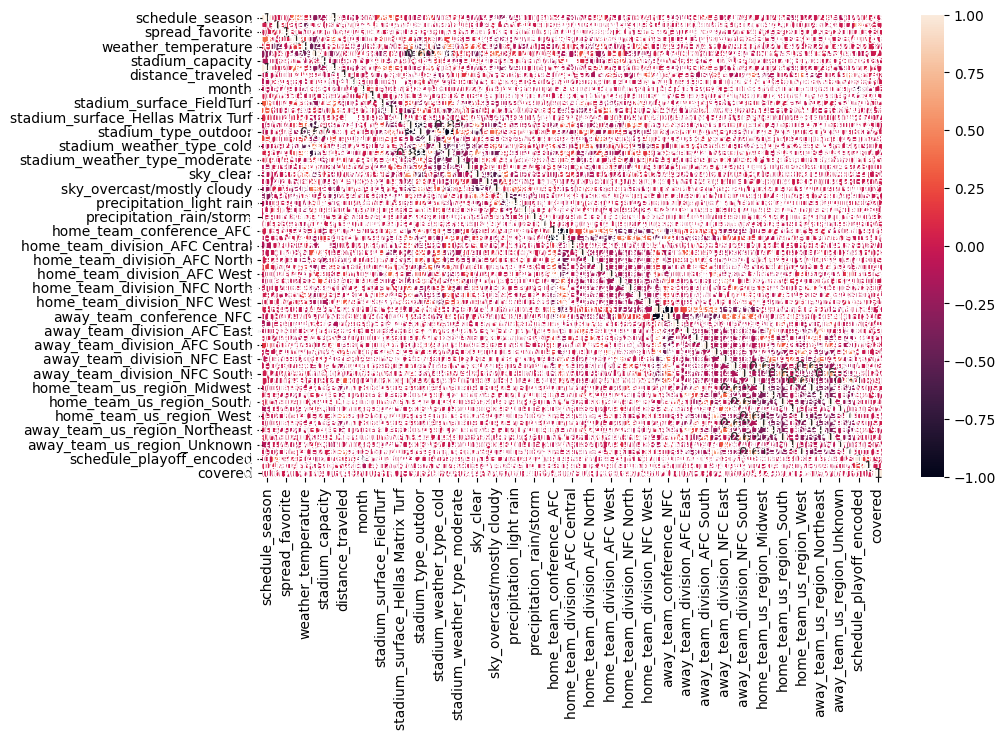

In [68]:
plt.figure(figsize=(10,6))
sns.heatmap(cov_cor, annot=True)

Based on initial observations, it seems that there might be stronger correlations between the features and the outcome variable 'cover' compared to 'favorite'.

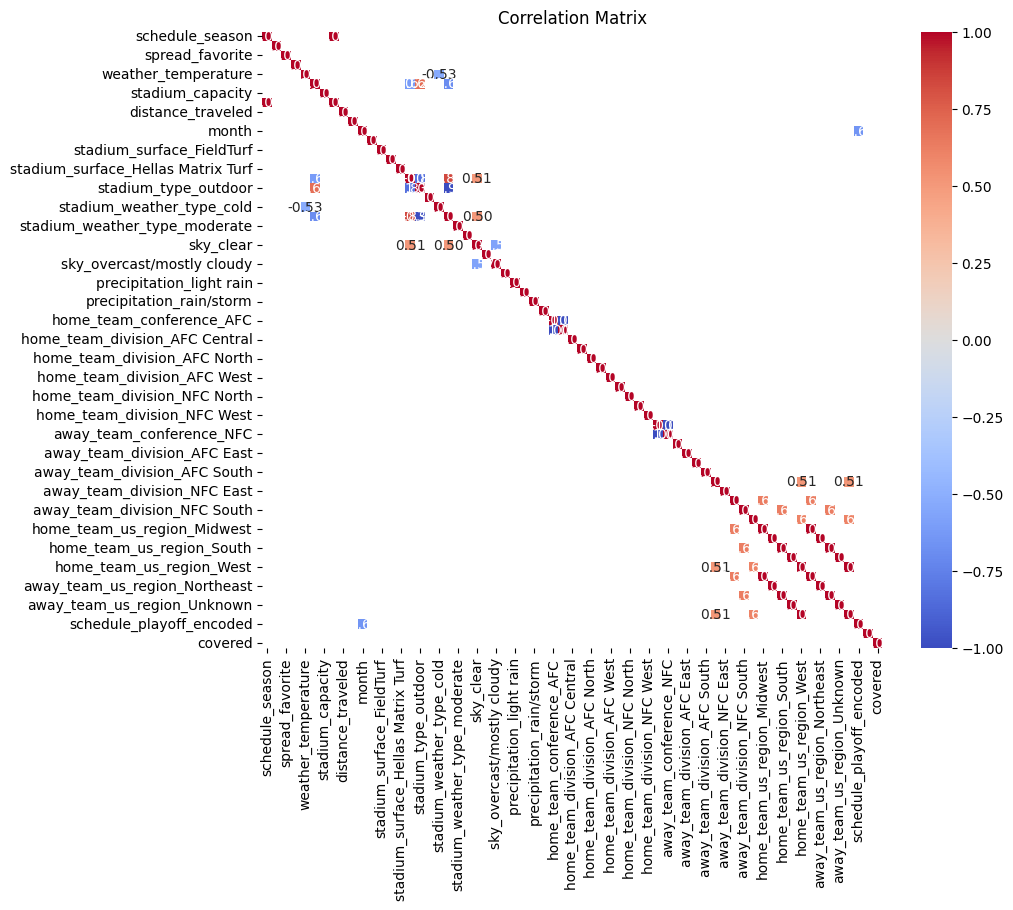

In [85]:
# Set a threshold
threshold = 0.5

# Mask correlations below the threshold
cov_cor_masked = cov_cor.mask(np.abs(cov_cor) <= threshold)

# Visualize the masked correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_cor_masked, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [73]:
threshold=0.04
a=abs(cov_cor['covered'])
cov_sig_feat=a[a>threshold]
cov_sig_feat

covered    1.0
Name: covered, dtype: float64

In [74]:
threshold=0.03
a=abs(cov_cor['covered'])
cov_sig_feat=a[a>threshold]
cov_sig_feat

covered    1.0
Name: covered, dtype: float64

In [72]:
threshold=0.02
a=abs(cov_cor['covered'])
cov_sig_feat=a[a>threshold]
cov_sig_feat

weather_temperature              0.023568
sky_clear/cloudy mix             0.023059
away_team_division_NFC West      0.024252
home_team_us_region_Midwest      0.027226
home_team_us_region_Northeast    0.026451
away_team_us_region_Midwest      0.027226
away_team_us_region_Northeast    0.026451
covered                          1.000000
Name: covered, dtype: float64

I was wrong we see less correlation with covered.

In [75]:
# Create dataframe to focus on did the spread cover
exclude_columns=['did_favorite_win', 'covered']
 
over = df.drop(exclude_columns, axis=1)


In [76]:
over_cor= over.corr()
over_cor

schedule_season  schedule_week  spread_favorite  \
schedule_season                     1.000000       0.018648         0.023063   
schedule_week                       0.018648       1.000000         0.083098   
spread_favorite                     0.023063       0.083098         1.000000   
over_under_line                     0.389558      -0.001151         0.051719   
weather_temperature                 0.103496      -0.454040        -0.060670   
...                                      ...            ...              ...   
away_team_us_region_Unknown        -0.116839       0.007222        -0.016642   
away_team_us_region_West           -0.021576      -0.015006        -0.013446   
schedule_playoff_encoded           -0.003694       0.416302         0.028154   
stadium_neutral_encoded             0.049420       0.082385         0.001537   
did_over_hit                        0.002789      -0.002015         0.002818   

                             over_under_line  weather_temperature  \
schedule_season                     0.389558             0.103496   
schedule_week                      -0.001151            -0.454040   
spread_favorite                     0.051719            -0.060670   
over_under_line                     1.000000             0.170461   
weather_temperature                 0.170461             1.000000   
...                                      ...                  ...   
away_team_us_region_Unknown        -0.033511            -0.017703   
away_team_us_region_West            0.040507             0.011841   
schedule_playoff_encoded            0.073625            -0.011663   
stadium_neutral_encoded             0.066309             0.037718   
did_over_hit                       -0.026573            -0.003083   

                             weather_wind_mph  stadium_capacity      year  \
schedule_season                     -0.280030         -0.130582  0.999822   
schedule_week                        0.018047         -0.006453  0.027175   
spread_favorite                      0.024668          0.015069  0.023763   
over_under_line                     -0.275517          0.025570  0.389829   
weather_temperature                 -0.428438         -0.088947  0.102343   
...                                       ...               ...       ...   
away_team_us_region_Unknown          0.050246         -0.007181 -0.116669   
away_team_us_region_West            -0.013448          0.037836 -0.021617   
schedule_playoff_encoded            -0.067199          0.017665  0.010287   
stadium_neutral_encoded             -0.027975         -0.005234  0.052222   
did_over_hit                        -0.044256         -0.003822  0.002702   

                             distance_traveled  fog_or_haze  ...  \
schedule_season                      -0.051032    -0.086815  ...   
schedule_week                        -0.001362     0.049441  ...   
spread_favorite                       0.014199     0.003777  ...   
over_under_line                       0.040222    -0.010945  ...   
weather_temperature                   0.093853    -0.073121  ...   
...                                        ...          ...  ...   
away_team_us_region_Unknown          -0.017155     0.028264  ...   
away_team_us_region_West              0.375447    -0.008497  ...   
schedule_playoff_encoded              0.064464     0.034778  ...   
stadium_neutral_encoded               0.037908     0.000187  ...   
did_over_hit                          0.016957     0.006584  ...   

                             home_team_us_region_Unknown  \
schedule_season                                -0.116839   
schedule_week                                   0.007222   
spread_favorite                                -0.016642   
over_under_line                                -0.033511   
weather_temperature                            -0.017703   
...                                                  ...   
away_team_us_region_Unknown                     1.000000   
away_team_us_regi

<AxesSubplot: >

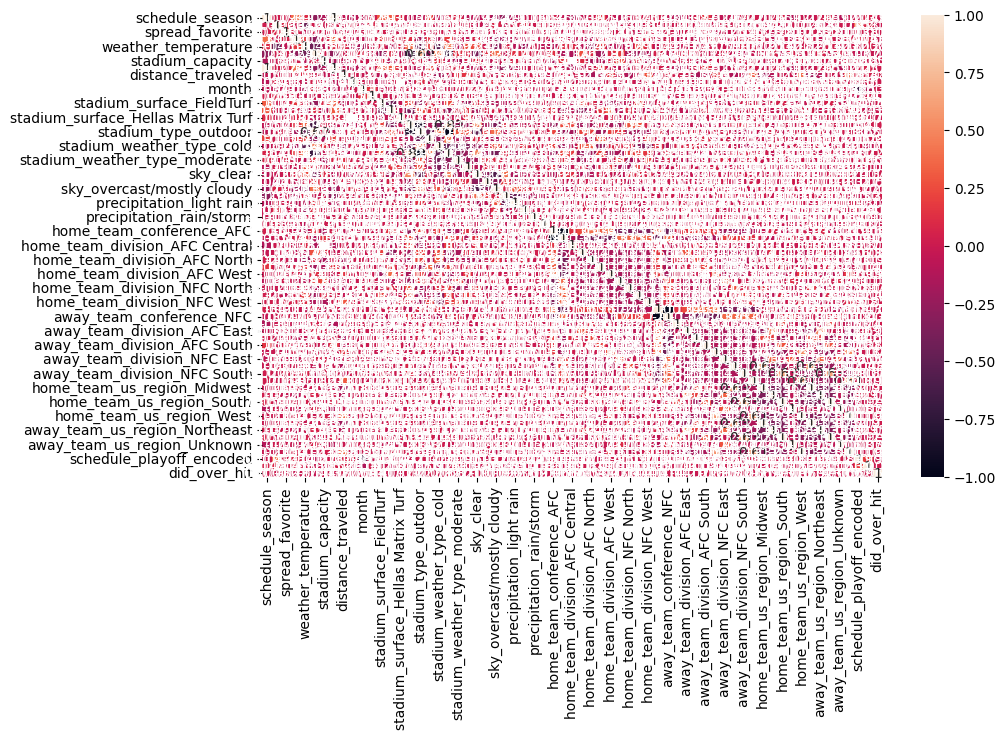

In [77]:
plt.figure(figsize=(10,6))
sns.heatmap(over_cor, annot=True)

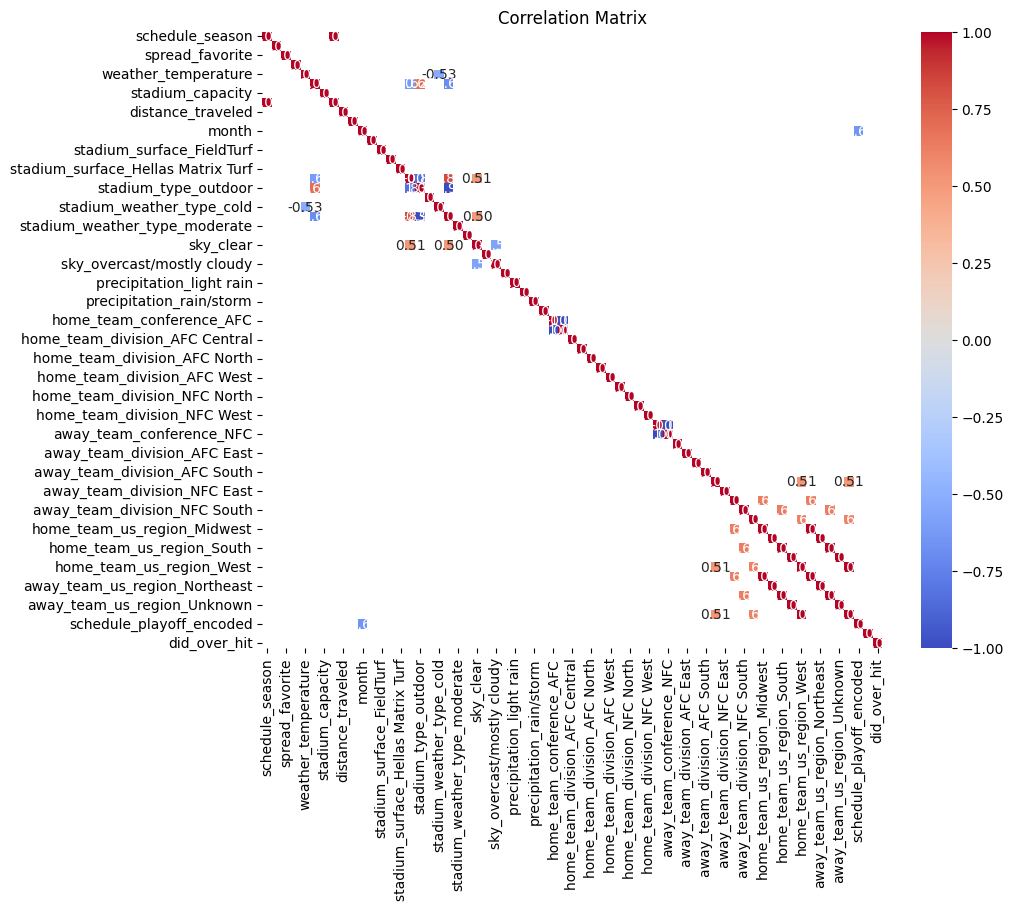

In [84]:
# Set a threshold
threshold = 0.5

# Mask correlations below the threshold
over_cor_masked = over_cor.mask(np.abs(over_cor) <= threshold)

# Visualize the masked correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(over_cor_masked, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [78]:
threshold=0.04
a=abs(over_cor['did_over_hit'])
over_sig_feat=a[a>threshold]
over_sig_feat

weather_wind_mph    0.044256
did_over_hit        1.000000
Name: did_over_hit, dtype: float64

In [79]:
threshold=0.03
a=abs(over_cor['did_over_hit'])
over_sig_feat=a[a>threshold]
over_sig_feat

weather_wind_mph            0.044256
precipitation_light rain    0.036191
did_over_hit                1.000000
Name: did_over_hit, dtype: float64

In [80]:
threshold=0.02
a=abs(over_cor['did_over_hit'])
over_sig_feat=a[a>threshold]
over_sig_feat

over_under_line                  0.026573
weather_wind_mph                 0.044256
stadium_type_outdoor             0.022038
stadium_weather_type_dome        0.022113
precipitation_None               0.027153
precipitation_light rain         0.036191
precipitation_rain/storm         0.022586
away_team_division_AFC North     0.022065
home_team_us_region_Northeast    0.022538
away_team_us_region_Northeast    0.022538
schedule_playoff_encoded         0.020744
did_over_hit                     1.000000
Name: did_over_hit, dtype: float64

Based on the analysis, there seems to be a slight correlation between weather conditions and the over/under outcome of the game. 

Pearson correlation provides a bit more insight compared to Chi-2, but the correlations observed are still relatively small. Specifically, there is a slight correlation between weather and the game outcome, particularly with the over/under result. Additionally, there is some indication of a correlation between Northeast teams and the over/under outcome. These findings are valuable considerations as we move forward with modeling.

We will now perform a t-test on our dataframe. The t-test is a statistical test used to compare the means of two groups (t-test). By analyzing the results of the t-test, we can determine whether to reject or accept the hypothesis.

In [87]:
def feature_selection_ttest_ind(df, target_col,exclude_columns=[], k=5):
    """
    Perform feature selection using independent t-test.

    Args:
        df (DataFrame): The input DataFrame.
        target_col (str): The name of the target column.
        k (int): The number of top features to select.

    Returns:
        Tuple[List[str], List[str], List[str]]: The top features without FDR correction,
                                                the top features after Benjamini-Hochberg FDR correction,
                                                the top features after Bonferroni FDR correction.
    """

    # Create a new series containing the target variable
    y = df[target_col]

    # Create a new dataframe containing only the features to be tested
    X = df.drop(exclude_columns, axis=1)

    # Use the t-test to identify the top k features
    t_scores, p_values = ttest_ind(X[y==0], X[y==1])
    selected_features = X.columns[p_values < 0.05][:k]

    # Print the top k significant features (no FDR)
    print(f'Top {len(selected_features)} Significant t-test Features (No FDR):')
    print(selected_features)

    # Apply Benjamini-Hochberg FDR method
    significant_features_bh = X.columns[multipletests(p_values, alpha=0.05, method='fdr_bh')[0]]
    top_features_bh = significant_features_bh[:k]

    # Print the top k significant features (BH FDR)
    print(f'Top {len(top_features_bh)} Significant t-test Features (BH FDR):')
    print(top_features_bh)

    # Apply bonferroni FDR method
    significant_features_bonferroni = X.columns[multipletests(p_values, alpha=0.05, method='bonferroni')[0]]
    top_features_bonferroni = significant_features_bonferroni[:k]

    # Print the top k significant features (bonferroni FDR)
    print(f'Top {len(top_features_bonferroni)} Significant t-test Features (bonferroni FDR):')
    print(top_features_bonferroni)

    # Return the top k significant feature names as a list
    return top_features_bh.tolist(), top_features_bonferroni.tolist(), selected_features.tolist()


In [88]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit', ]
top_features_favorite_ttest = feature_selection_ttest_ind(df,'did_favorite_win', exclude_columns, 64)

Top 15 Significant t-test Features (No FDR):
Index(['schedule_season', 'schedule_week', 'spread_favorite', 'year',
       'stadium_surface_FieldTurf', 'sky_clear', 'sky_clear/cloudy mix',
       'home_team_division_NFC South', 'away_team_division_AFC West',
       'away_team_division_NFC East', 'away_team_division_NFC West',
       'home_team_us_region_Midwest', 'home_team_us_region_Northeast',
       'away_team_us_region_Midwest', 'away_team_us_region_Northeast'],
      dtype='object')
Top 6 Significant t-test Features (BH FDR):
Index(['spread_favorite', 'stadium_surface_FieldTurf',
       'home_team_us_region_Midwest', 'home_team_us_region_Northeast',
       'away_team_us_region_Midwest', 'away_team_us_region_Northeast'],
      dtype='object')
Top 3 Significant t-test Features (bonferroni FDR):
Index(['spread_favorite', 'home_team_us_region_Northeast',
       'away_team_us_region_Northeast'],
      dtype='object')


In [89]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit', ]
top_features_covered_ttest = feature_selection_ttest_ind(df,'covered', exclude_columns, 64)

Top 10 Significant t-test Features (No FDR):
Index(['schedule_week', 'spread_favorite', 'stadium_type_outdoor',
       'sky_clear/cloudy mix', 'precipitation_snow',
       'away_team_division_NFC West', 'home_team_us_region_Midwest',
       'home_team_us_region_Northeast', 'away_team_us_region_Midwest',
       'away_team_us_region_Northeast'],
      dtype='object')
Top 0 Significant t-test Features (BH FDR):
Index([], dtype='object')
Top 0 Significant t-test Features (bonferroni FDR):
Index([], dtype='object')


In [90]:
exclude_columns=['did_favorite_win', 'covered', 'did_over_hit' ]
top_features_over_ttest = feature_selection_ttest_ind(df,'did_over_hit', exclude_columns, 64)

Top 11 Significant t-test Features (No FDR):
Index(['stadium_type_indoor', 'stadium_type_outdoor',
       'stadium_weather_type_dome', 'stadium_weather_type_warm',
       'precipitation_None', 'precipitation_light rain',
       'precipitation_rain/storm', 'away_team_division_AFC North',
       'home_team_us_region_Northeast', 'away_team_us_region_Northeast',
       'schedule_playoff_encoded'],
      dtype='object')
Top 1 Significant t-test Features (BH FDR):
Index(['precipitation_light rain'], dtype='object')
Top 1 Significant t-test Features (bonferroni FDR):
Index(['precipitation_light rain'], dtype='object')


Based on the results of the t-test, it seems that using a P-value threshold of < 0.05 returns a considerable number of features. This suggests that the t-test may be a suitable method for determining the feature list. However, it is important to note that not applying a False Discovery Rate (FDR) correction can be concerning as it may introduce false positives.

Considering the number of features with a P-value below the threshold, it is worth exploring this feature list further and evaluating its performance in the models. By including these features, we can potentially capture important signals and improve the predictive capability of the models.

Overall, the t-test results provide valuable insights and suggest that these features should be considered in the modeling process.

I would like to explore XGBoost for feature selection and assessing feature importance. While this algorithm was not discussed in this course, it belongs to the decision tree family and can determine the importance of a feature based on a series of if-then-else statements to construct a tree-like structure. I believe attempting this approach will provide valuable insights into the importance of features for the target variable.

In [93]:
def train_xgboost_classifier(data, target_columns, target_col):
    """
    Trains an XGBoost classifier on the given data and evaluates its performance.

    Parameters:
    - data (DataFrame): The input data containing features and target variables.
    - target_columns (list): List of columns to be used as target variables.
    - target_col (str): The specific target column to predict.

    Returns:
    None
    """
    # Separate the features (X) and the target variables (y)
    X = data.drop(target_columns, axis=1)
    y = data[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create an XGBoost classifier
    model = xgb.XGBClassifier()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Access the feature importance
    feature_importance = model.feature_importances_
    print("Feature Importance:")
    for feature, importance in zip(X.columns, feature_importance):
        print(f"{feature}: {importance}")


In [94]:
target_columns = ['did_favorite_win', 'covered', 'did_over_hit'] 

train_xgboost_classifier(df, target_columns,'did_favorite_win')

Accuracy: 0.621658359764386
Feature Importance:
schedule_season: 0.018125563859939575
schedule_week: 0.017105096951127052
spread_favorite: 0.040541861206293106
over_under_line: 0.016701288521289825
weather_temperature: 0.01766476035118103
weather_wind_mph: 0.01783916912972927
stadium_capacity: 0.018160786479711533
year: 0.015791911631822586
distance_traveled: 0.017723429948091507
fog_or_haze: 0.02153693325817585
month: 0.019449979066848755
day: 0.01646312326192856
stadium_surface_FieldTurf: 0.022524096071720123
stadium_surface_Grass: 0.017415838316082954
stadium_surface_Hellas Matrix Turf: 0.015736835077404976
stadium_type_indoor: 0.008899116888642311
stadium_type_outdoor: 0.023940397426486015
stadium_type_retractable: 0.018411852419376373
stadium_weather_type_cold: 0.023615362122654915
stadium_weather_type_dome: 0.029295869171619415
stadium_weather_type_moderate: 0.01822933927178383
stadium_weather_type_warm: 0.017793774604797363
sky_clear: 0.01966996304690838
sky_clear/cloudy mix: 0.

In [95]:
target_columns = ['did_favorite_win', 'covered', 'did_over_hit', ]

train_xgboost_classifier(df, target_columns,'covered')

Accuracy: 0.5111010421386497
Feature Importance:
schedule_season: 0.019503476098179817
schedule_week: 0.018525434657931328
spread_favorite: 0.02198563702404499
over_under_line: 0.01826668158173561
weather_temperature: 0.017387617379426956
weather_wind_mph: 0.017294762656092644
stadium_capacity: 0.01996418461203575
year: 0.017886167392134666
distance_traveled: 0.01953347586095333
fog_or_haze: 0.016676776111125946
month: 0.018146533519029617
day: 0.01757773570716381
stadium_surface_FieldTurf: 0.02083422988653183
stadium_surface_Grass: 0.015273598954081535
stadium_surface_Hellas Matrix Turf: 0.012564226984977722
stadium_type_indoor: 0.02109178900718689
stadium_type_outdoor: 0.02641056291759014
stadium_type_retractable: 0.015946097671985626
stadium_weather_type_cold: 0.01799304038286209
stadium_weather_type_dome: 0.0
stadium_weather_type_moderate: 0.015035310760140419
stadium_weather_type_warm: 0.022314082831144333
sky_clear: 0.019423699006438255
sky_clear/cloudy mix: 0.02164081484079361
s

In [96]:
target_columns = ['did_favorite_win', 'covered', 'did_over_hit', ]

train_xgboost_classifier(df, target_columns,'did_over_hit')

Accuracy: 0.5002265518803806
Feature Importance:
schedule_season: 0.018079066649079323
schedule_week: 0.01839699223637581
spread_favorite: 0.018626609817147255
over_under_line: 0.020469646900892258
weather_temperature: 0.019831163808703423
weather_wind_mph: 0.01939663104712963
stadium_capacity: 0.019805872812867165
year: 0.017728524282574654
distance_traveled: 0.019770847633481026
fog_or_haze: 0.02517903596162796
month: 0.01897408813238144
day: 0.018408117815852165
stadium_surface_FieldTurf: 0.01904279738664627
stadium_surface_Grass: 0.021179936826229095
stadium_surface_Hellas Matrix Turf: 0.00795662123709917
stadium_type_indoor: 0.021950386464595795
stadium_type_outdoor: 0.018453771248459816
stadium_type_retractable: 0.016276465728878975
stadium_weather_type_cold: 0.017649218440055847
stadium_weather_type_dome: 0.0
stadium_weather_type_moderate: 0.022088659927248955
stadium_weather_type_warm: 0.018385635688900948
sky_clear: 0.018893256783485413
sky_clear/cloudy mix: 0.0198104139417409

Looking over the results, it appears that the XGBoost feature importance values are not significantly higher than the values obtained from the statistical methods. This indicates that across all the feature selection methods employed, we consistently observe relatively low significance and importance for the features.

Conducting the XGBoost analysis was a necessary step to validate and confirm the consistency of the results obtained from the statistical methods. The lack of substantial variations in feature importance reinforces the notion that the dataset exhibits limited predictability and challenges in identifying strong signals or patterns for predicting the target variable.

## Modeling

Now that we have completed the feature selection process, it is time to proceed with modeling and testing the performance of our models. While we didn't achieve a significant breakthrough in terms of confidence from the feature selection phase, there were some promising findings. I am hopeful that by incorporating these selected features into our models, we can potentially improve upon the baseline metrics we established earlier.

I will now introduce the widely used K-means Clustering algorithm. K-means clustering is a method of vector quantization that originated in signal processing. Its objective is to partition a set of n observations into k clusters, where each observation is assigned to the cluster with the closest mean (also known as the cluster center or centroid). The mean of each cluster serves as a prototype for that particular cluster. (KMeans)

In [109]:
# Normalize all numeric columns to get to a more normal curve
normalize_cols = ['spread_favorite', 'over_under_line', 'weather_temperature', 'weather_wind_mph', 'stadium_capacity', 'distance_traveled']
fav.loc[:,normalize_cols] = MinMaxScaler().fit_transform(fav.loc[:,normalize_cols])
fav.head()

schedule_season  schedule_week  spread_favorite  over_under_line  \
0             1979              1         0.113208         0.056338   
1             1979              3         0.226415         0.394366   
2             1979              6         0.490566         0.338028   
3             1979              7         0.150943         0.225352   
4             1979              8         0.264151         0.394366   

   weather_temperature  weather_wind_mph  stadium_capacity  year  \
0             0.825243             0.225               NaN  1979   
1             0.689320             0.250               NaN  1979   
2             0.601942             0.325               NaN  1979   
3             0.456311             0.250          0.806771  1979   
4             0.757282             0.000          0.742707  1979   

   distance_traveled  fog_or_haze  ...  home_team_us_region_Unknown  \
0           0.366172          NaN  ...                            0   
1           0.193392          NaN  ...                            0   
2           0.216429          NaN  ...                            0   
3           0.119430          NaN  ...                            0   
4           0.331616          NaN  ...                            0   

   home_team_us_region_West  away_team_us_region_Midwest  \
0                         0                            1   
1                         0                            1   
2                         0                            1   
3                         0                            1   
4                         0                            1   

   away_team_us_region_Northeast  away_team_us_region_South  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   away_team_us_region_Unknown  away_team_us_region_West  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   schedule_playoff_encoded  stadium_neutral_encoded  did_favorite_win  
0                         0                        0                 1  
1                         0                        0                 1  
2                         0                        0                 1  
3                         0                        0                 1  
4                         0                        0                 1  

[5 rows x 65 columns]

In [110]:
print(len(fav))

11031


In [113]:
# Drop NaN rows
fav_norm = fav.dropna()


In [115]:
print(len(fav_norm))
fav_norm.head()

5085


schedule_season  schedule_week  spread_favorite  over_under_line  \
233             1980              1         0.113208         0.197183   
237             1980              9         0.264151         0.394366   
243             1980              5         0.037736         0.197183   
247             1980             13         0.150943         0.281690   
249             1980              1         0.226415         0.197183   

     weather_temperature  weather_wind_mph  stadium_capacity  year  \
233             0.679612             0.200          0.705157  1980   
237             0.621359             0.150          0.394115  1980   
243             0.533981             0.350          0.517979  1980   
247             0.417476             0.400          0.806771  1980   
249             0.689320             0.125          0.806771  1980   

     distance_traveled  fog_or_haze  ...  home_team_us_region_Unknown  \
233           0.420430          0.0  ...                            0   
237           0.919673          0.0  ...                            0   
243           0.355865          0.0  ...                            0   
247           0.418915          0.0  ...                            0   
249           0.062746          0.0  ...                            0   

     home_team_us_region_West  away_team_us_region_Midwest  \
233                         0                            0   
237                         0                            0   
243                         0                            0   
247                         0                            0   
249                         0                            1   

     away_team_us_region_Northeast  away_team_us_region_South  \
233                              0                          1   
237                              0                          1   
243                              0                          1   
247                              0                          1   
249                              0                          0   

     away_team_us_region_Unknown  away_team_us_region_West  \
233                            0                         0   
237                            0                         0   
243                            0                         0   
247                            0                         0   
249                            0                         0   

     schedule_playoff_encoded  stadium_neutral_encoded  did_favorite_win  
233                         0                        0                 0  
237                         0                        0                 1  
243                         0                        0                 0  
247                         0                        0                 0  
249                         0                        0                 0  

[5 rows x 65 columns]

In [136]:
# Create dataframe with only features selected from the ttest
columns_to_keep = ['schedule_season', 'schedule_week', 'spread_favorite', 'year',
       'stadium_surface_FieldTurf', 'sky_clear', 'sky_clear/cloudy mix',
       'home_team_division_NFC South', 'away_team_division_AFC West',
       'away_team_division_NFC East', 'away_team_division_NFC West',
       'home_team_us_region_Midwest', 'home_team_us_region_Northeast',
       'away_team_us_region_Midwest', 'away_team_us_region_Northeast', 'did_favorite_win']

fav_final = fav_norm[columns_to_keep]


In [138]:
np.random.seed(4455)

# Fit KMeans clustering and assign cluster assignments
fav_final['cluster_assignments'] = KMeans(n_clusters=5, n_init=10).fit_predict(fav_final)

# Create a frequency table of the number of entries by cluster assignment
fav_frequency_table = fav_final.loc[:, ['cluster_assignments', 'did_favorite_win']].value_counts().sort_index()

# Print the frequency table
print(fav_frequency_table)

cluster_assignments  did_favorite_win
0                    0                   299
                     1                   579
1                    0                   390
                     1                   682
2                    0                   223
                     1                   381
3                    0                   336
                     1                   736
4                    0                   499
                     1                   960
dtype: int64


/var/folders/1t/80l84r3x6cdd84jj6kf4yxdc0000gn/T/ipykernel_70413/759259479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fav_final['cluster_assignments'] = KMeans(n_clusters=5, n_init=10).fit_predict(fav_final)


As expected, there is a significant overlap in the cluster assignments, which can make it challenging to identify clear patterns or signals in the data. 

We will now attempt to determine the appropriate amount of clusters.

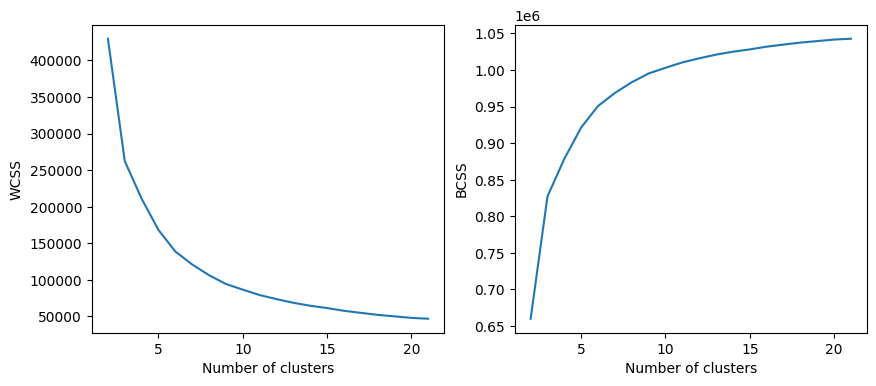

In [141]:
def cluster_search_kmeans(df, nclusts=(2,21)):
    ## If there are cluster assignments in the data frame remove them. 
    if 'cluster_assignments' in df.columns: df.drop(columns='cluster_assignments', inplace=True)
    WCSS=[]
    BCSS=[]
    ## Compute total sum of squares
    x_bar = np.mean(df, axis=0)
    TSS = np.sum(np.sum(np.square(df - x_bar)))
    ## Put your code below
    for n in range(nclusts[0],nclusts[1]+1):   
        temp_model = KMeans(n_clusters=n, n_init = 10).fit(df)
        WCSS.append(temp_model.inertia_)
        BCSS.append(TSS - temp_model.inertia_)
    _, ax = plt.subplots(1,2, figsize=(10,4))    
    ax[0].plot(range(nclusts[0],nclusts[1]+1),WCSS)   
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[1].plot(range(nclusts[0],nclusts[1]+1),BCSS)   
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
 
np.random.seed(4455)
cluster_search_kmeans(fav_final)    

It appears 6 clusters may be the best number here.

In [142]:
np.random.seed(4455)
## Put your code below
if 'cluster_assignments' in fav_final.columns: fav_final.drop(columns='cluster_assignments', inplace=True)
    
## Get the start time for the k-means algorithm and execute the algorithm
start_time = time.process_time()
fav_final['cluster_assignments'] = KMeans(n_clusters=6, n_init=40).fit_predict(fav_final)
## Display the execution time
print('Execution time =', time.process_time() - start_time, "seconds")

## Dispaly the frequence table by cluster assignment
fav_final.loc[:,['cluster_assignments','did_favorite_win']].value_counts().sort_index(axis=0, level=0)

Execution time = 2.3673949999999877 seconds


/var/folders/1t/80l84r3x6cdd84jj6kf4yxdc0000gn/T/ipykernel_70413/364915719.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fav_final['cluster_assignments'] = KMeans(n_clusters=6, n_init=40).fit_predict(fav_final)


cluster_assignments  did_favorite_win
0                    0                   293
                     1                   518
1                    0                   299
                     1                   637
2                    0                   214
                     1                   349
3                    0                   375
                     1                   647
4                    0                   257
                     1                   505
5                    0                   309
                     1                   682
dtype: int64

Still a significant amount of overlap in each cluster.

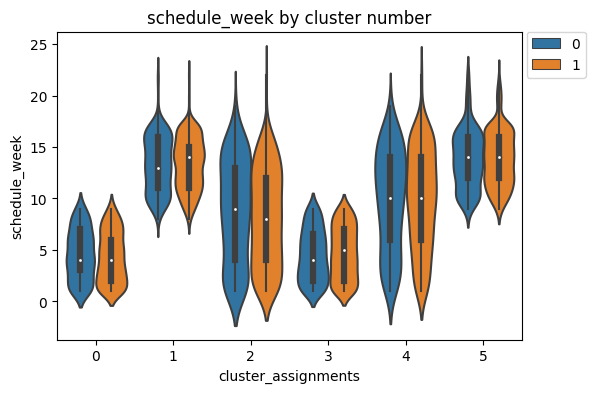

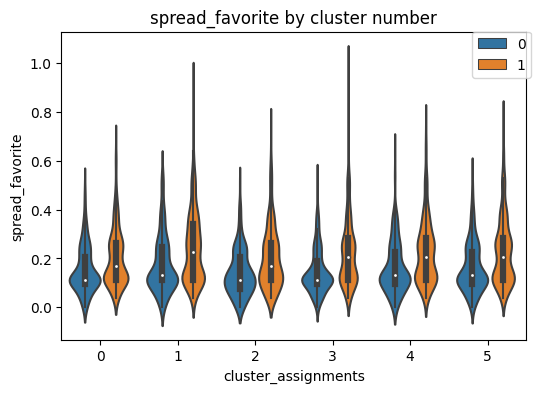

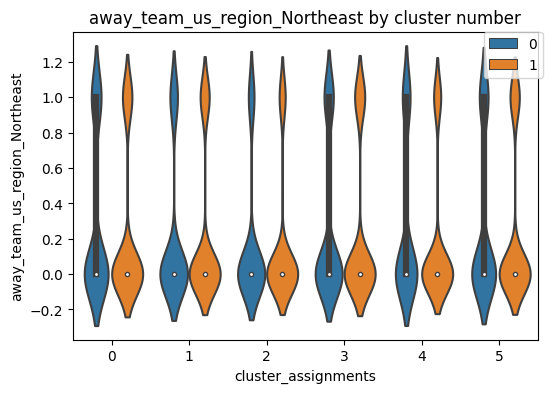

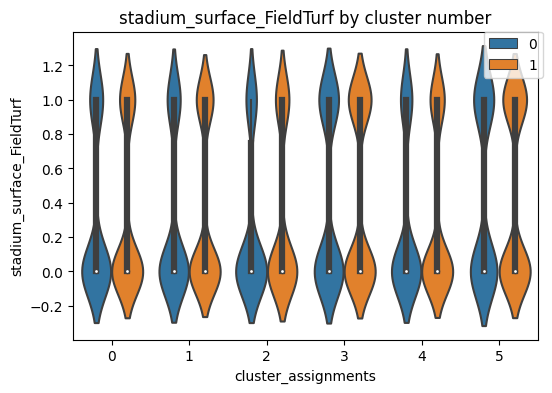

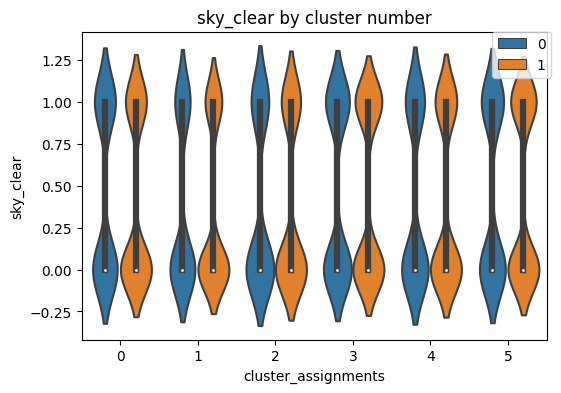

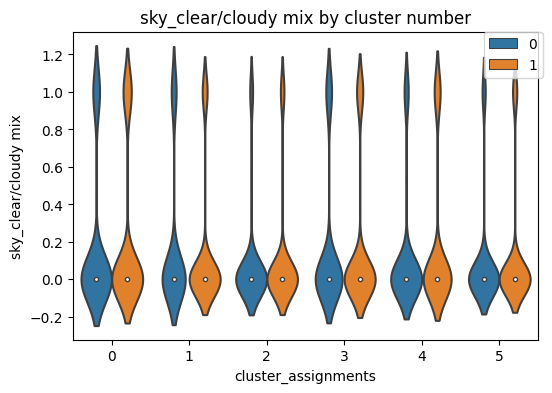

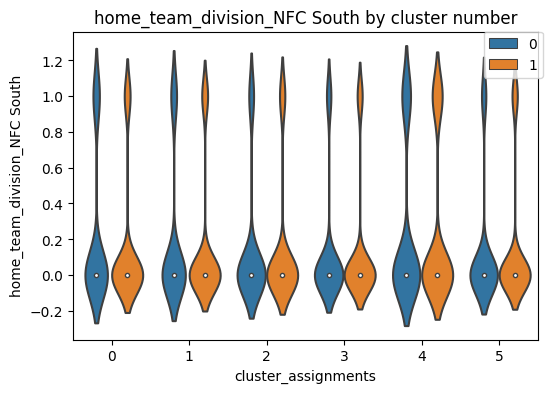

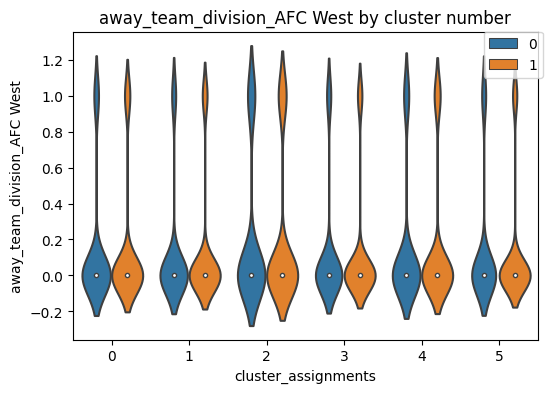

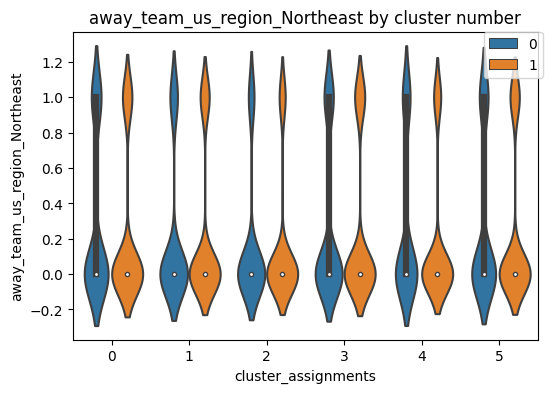

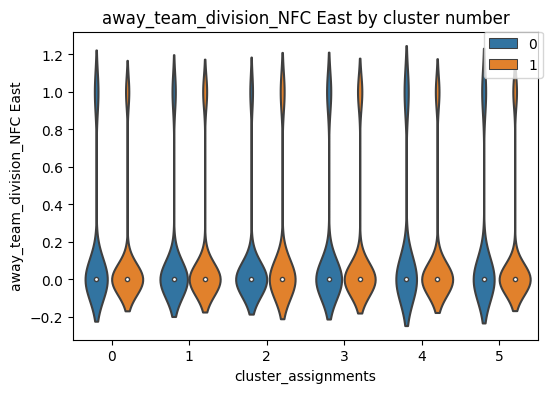

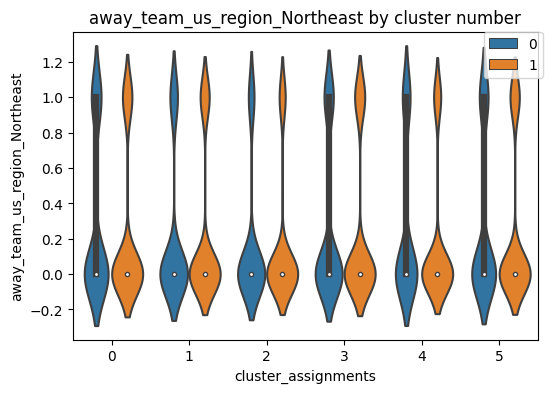

In [147]:
# Plot the cluster assignment compared to the factor
def plot_clusters_by_factor(df, factor='schedule_week', type='violin'):
    plt.figure(figsize=(6,4))
    if(type=='violin'):
        ax=sns.violinplot(x='cluster_assignments', y=factor, hue='did_favorite_win', data=df)
    else: 
        ax=sns.boxplot(x='cluster_assignments', y=factor, hue='did_favorite_win', data=df)
    ax.set_title(factor + ' by cluster number')
    plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
    
plot_clusters_by_factor(fav_final)    
plot_clusters_by_factor(fav_final, factor='spread_favorite')  
plot_clusters_by_factor(fav_final, factor='away_team_us_region_Northeast')  
plot_clusters_by_factor(fav_final, factor='stadium_surface_FieldTurf')  
plot_clusters_by_factor(fav_final, factor='sky_clear') 
plot_clusters_by_factor(fav_final, factor='sky_clear/cloudy mix')  
plot_clusters_by_factor(fav_final, factor='home_team_division_NFC South') 
plot_clusters_by_factor(fav_final, factor='away_team_division_AFC West')  
plot_clusters_by_factor(fav_final, factor='away_team_us_region_Northeast') 
plot_clusters_by_factor(fav_final, factor='away_team_division_NFC East')  
plot_clusters_by_factor(fav_final, factor='away_team_us_region_Northeast') 


As what has been the case this whole report. Using a subset of the factors we can see there is no real distinct difference between the favorite winning or not from this violin chart everything seems to be too close to tell with a lot of overlap. The features here may be too binary to effectively capture the distance.

Now, let's assess whether we can achieve improved cluster assignments by using Mini-Batch K-means.

In [152]:
## Remove cluster assignment column from df if it exists
if 'cluster_assignments' in fav_final.columns: fav_final.drop(columns='cluster_assignments', inplace=True)
    
## Get the start time for the k-means algorithm
start_time = time.process_time()
fav_final['cluster_assignments'] = MiniBatchKMeans(n_clusters=6, batch_size=256, n_init =10).fit_predict(fav_final)
## Display the execution time
print('Execution time =', time.process_time() - start_time, "seconds")

## Print the frequency table by cluster assignments
fav_final.loc[:,['cluster_assignments','did_favorite_win']].value_counts().sort_index(axis=0, level=0)

Execution time = 0.984956000000011 seconds


/var/folders/1t/80l84r3x6cdd84jj6kf4yxdc0000gn/T/ipykernel_70413/678543277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if 'cluster_assignments' in fav_final.columns: fav_final.drop(columns='cluster_assignments', inplace=True)
/var/folders/1t/80l84r3x6cdd84jj6kf4yxdc0000gn/T/ipykernel_70413/678543277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fav_final['cluster_assignments'] = MiniBatchKMeans(n_clusters=6, batch_size=256, n_init =10).fit_predict(fav_final)


cluster_assignments  did_favorite_win
0                    0                   214
                     1                   348
1                    0                   375
                     1                   647
2                    0                   293
                     1                   631
3                    0                   309
                     1                   682
4                    0                   257
                     1                   506
5                    0                   299
                     1                   524
dtype: int64

After this initial attempt using only the 'did_favorite_win' column, it is becoming evident that K-means clustering and K-means Mini batch clustering may not be the most suitable solutions for this problem. Since our problem is more of a supervised learning problem, I will halt further exploration with these clustering methods to save time. Instead, I will proceed with looking into logistic regression models.

In [162]:
def logistic_regression_model(df, target_col, features, test_size=0.2):
    # Load your dataset and separate your features and targets
    # features
    X = df[features]
    # Create a new series containing the target variable
    y = df[target_col]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Create a Logistic Regression classifier and fit the model
    clf = LogisticRegression(random_state=0, multi_class='auto', solver='liblinear')
    clf.fit(X_train, y_train)

    # Make predictions on the testing set and calculate accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy
    print('Accuracy:', accuracy)

In [168]:
# Run logistic regression model on features returned by the ttest
features = ['schedule_season', 'schedule_week', 'spread_favorite', 'year',
       'stadium_surface_FieldTurf', 'sky_clear', 'sky_clear/cloudy mix',
       'home_team_division_NFC South', 'away_team_division_AFC West',
       'away_team_division_NFC East', 'away_team_division_NFC West',
       'home_team_us_region_Midwest', 'home_team_us_region_Northeast',
       'away_team_us_region_Midwest', 'away_team_us_region_Northeast']
logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.5)
logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.4)
logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.3)
logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.2)
logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.1)

Accuracy: 0.6712544239087692
Accuracy: 0.6656833824975418
Accuracy: 0.6677588466579292
Accuracy: 0.688298918387414
Accuracy: 0.6974459724950884


In [165]:

columns_except_target = fav_norm.drop('did_favorite_win', axis=1).columns.tolist()


In [167]:
# Run logistic regression model on all features
logistic_regression_model(fav_norm, 'did_favorite_win', columns_except_target, test_size=0.5)
logistic_regression_model(fav_norm, 'did_favorite_win', columns_except_target, test_size=0.4)
logistic_regression_model(fav_norm, 'did_favorite_win', columns_except_target, test_size=0.3)
logistic_regression_model(fav_norm, 'did_favorite_win', columns_except_target, test_size=0.2)


Accuracy: 0.6641761698780967
Accuracy: 0.6661750245821042
Accuracy: 0.6657929226736566
Accuracy: 0.6804326450344149


I experimented with different solvers in logistic regression but found that the results remained consistent. However, we do observe a slight increase in accuracy when using smaller test sizes for both the feature-reduced list and the total feature list.

In [169]:
# Normalize the numeric columns in the df
normalize_cols = ['spread_favorite', 'over_under_line', 'weather_temperature', 'weather_wind_mph', 'stadium_capacity', 'distance_traveled']
cov.loc[:,normalize_cols] = MinMaxScaler().fit_transform(cov.loc[:,normalize_cols])
cov.head()

schedule_season  schedule_week  spread_favorite  over_under_line  \
0             1979              1         0.113208         0.056338   
1             1979              3         0.226415         0.394366   
2             1979              6         0.490566         0.338028   
3             1979              7         0.150943         0.225352   
4             1979              8         0.264151         0.394366   

   weather_temperature  weather_wind_mph  stadium_capacity  year  \
0             0.825243             0.225               NaN  1979   
1             0.689320             0.250               NaN  1979   
2             0.601942             0.325               NaN  1979   
3             0.456311             0.250          0.806771  1979   
4             0.757282             0.000          0.742707  1979   

   distance_traveled  fog_or_haze  ...  home_team_us_region_Unknown  \
0           0.366172          NaN  ...                            0   
1           0.193392          NaN  ...                            0   
2           0.216429          NaN  ...                            0   
3           0.119430          NaN  ...                            0   
4           0.331616          NaN  ...                            0   

   home_team_us_region_West  away_team_us_region_Midwest  \
0                         0                            1   
1                         0                            1   
2                         0                            1   
3                         0                            1   
4                         0                            1   

   away_team_us_region_Northeast  away_team_us_region_South  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   away_team_us_region_Unknown  away_team_us_region_West  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   schedule_playoff_encoded  stadium_neutral_encoded  covered  
0                         0                        0        1  
1                         0                        0        1  
2                         0                        0        0  
3                         0                        0        1  
4                         0                        0        1  

[5 rows x 65 columns]

In [170]:
# Drop NaN rows
cov_norm = cov.dropna()


In [174]:
columns_to_keep = ['schedule_week', 'spread_favorite', 'stadium_type_outdoor',
       'sky_clear/cloudy mix', 'precipitation_snow',
       'away_team_division_NFC West', 'home_team_us_region_Midwest',
       'home_team_us_region_Northeast', 'away_team_us_region_Midwest',
       'away_team_us_region_Northeast', 'covered']

# Create new dataframe containing only features that are significant according to the ttest
cov_final = cov_norm[columns_to_keep]

In [176]:
# Run logistic regression model on features returned by the ttest
features = ['schedule_week', 'spread_favorite', 'stadium_type_outdoor',
       'sky_clear/cloudy mix', 'precipitation_snow',
       'away_team_division_NFC West', 'home_team_us_region_Midwest',
       'home_team_us_region_Northeast', 'away_team_us_region_Midwest',
       'away_team_us_region_Northeast']
logistic_regression_model(cov_final, 'covered', features, test_size=0.5)
logistic_regression_model(cov_final, 'covered', features, test_size=0.4)
logistic_regression_model(cov_final, 'covered', features, test_size=0.3)
logistic_regression_model(cov_final, 'covered', features, test_size=0.2)
logistic_regression_model(cov_final, 'covered', features, test_size=0.1)

Accuracy: 0.5139598898938262
Accuracy: 0.5083579154375615
Accuracy: 0.5019659239842726
Accuracy: 0.49852507374631266
Accuracy: 0.5088408644400786


In [ ]:
columns_except_target = cov_norm.drop('covered', axis=1).columns.tolist()


In [182]:
# Run logistic regression model on all features
logistic_regression_model(cov_norm, 'covered', columns_except_target, test_size=0.5)
logistic_regression_model(cov_norm, 'covered', columns_except_target, test_size=0.4)
logistic_regression_model(cov_norm, 'covered', columns_except_target, test_size=0.3)
logistic_regression_model(cov_norm, 'covered', columns_except_target, test_size=0.2)

Accuracy: 0.5159260715690129
Accuracy: 0.5103244837758112
Accuracy: 0.5039318479685452
Accuracy: 0.4936086529006883


In [183]:
# Normalize the numeric columns in the the df
normalize_cols = ['spread_favorite', 'over_under_line', 'weather_temperature', 'weather_wind_mph', 'stadium_capacity', 'distance_traveled']
over.loc[:,normalize_cols] = MinMaxScaler().fit_transform(over.loc[:,normalize_cols])
over.head()

schedule_season  schedule_week  spread_favorite  over_under_line  \
0             1979              1         0.113208         0.056338   
1             1979              3         0.226415         0.394366   
2             1979              6         0.490566         0.338028   
3             1979              7         0.150943         0.225352   
4             1979              8         0.264151         0.394366   

   weather_temperature  weather_wind_mph  stadium_capacity  year  \
0             0.825243             0.225               NaN  1979   
1             0.689320             0.250               NaN  1979   
2             0.601942             0.325               NaN  1979   
3             0.456311             0.250          0.806771  1979   
4             0.757282             0.000          0.742707  1979   

   distance_traveled  fog_or_haze  ...  home_team_us_region_Unknown  \
0           0.366172          NaN  ...                            0   
1           0.193392          NaN  ...                            0   
2           0.216429          NaN  ...                            0   
3           0.119430          NaN  ...                            0   
4           0.331616          NaN  ...                            0   

   home_team_us_region_West  away_team_us_region_Midwest  \
0                         0                            1   
1                         0                            1   
2                         0                            1   
3                         0                            1   
4                         0                            1   

   away_team_us_region_Northeast  away_team_us_region_South  \
0                              0                          0   
1                              0                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   

   away_team_us_region_Unknown  away_team_us_region_West  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   

   schedule_playoff_encoded  stadium_neutral_encoded  did_over_hit  
0                         0                        0             1  
1                         0                        0             0  
2                         0                        0             1  
3                         0                        0             1  
4                         0                        0             0  

[5 rows x 65 columns]

In [184]:
# Drop NaN rows
over_norm = over.dropna()


In [185]:
columns_to_keep = ['stadium_type_indoor', 'stadium_type_outdoor',
       'stadium_weather_type_dome', 'stadium_weather_type_warm',
       'precipitation_None', 'precipitation_light rain',
       'precipitation_rain/storm', 'away_team_division_AFC North',
       'home_team_us_region_Northeast', 'away_team_us_region_Northeast',
       'schedule_playoff_encoded', 'did_over_hit']

# Create new dataframe containing only features that are significant according to the ttest
over_final = over_norm[columns_to_keep]

In [186]:
# Run logistic regression model on features returned by the ttest
features = ['stadium_type_indoor', 'stadium_type_outdoor',
       'stadium_weather_type_dome', 'stadium_weather_type_warm',
       'precipitation_None', 'precipitation_light rain',
       'precipitation_rain/storm', 'away_team_division_AFC North',
       'home_team_us_region_Northeast', 'away_team_us_region_Northeast',
       'schedule_playoff_encoded']
logistic_regression_model(over_final, 'did_over_hit', features, test_size=0.5)
logistic_regression_model(over_final, 'did_over_hit', features, test_size=0.4)
logistic_regression_model(over_final, 'did_over_hit', features, test_size=0.3)
logistic_regression_model(over_final, 'did_over_hit', features, test_size=0.2)
logistic_regression_model(over_final, 'did_over_hit', features, test_size=0.1)

Accuracy: 0.5104207628784899
Accuracy: 0.5172074729596854
Accuracy: 0.5150720838794234
Accuracy: 0.5083579154375615
Accuracy: 0.49901768172888017


In [187]:
columns_except_target = over_norm.drop('did_over_hit', axis=1).columns.tolist()

In [188]:
# Run logistic regression model on all features
logistic_regression_model(over_norm, 'did_over_hit', columns_except_target, test_size=0.5)
logistic_regression_model(over_norm, 'did_over_hit', columns_except_target, test_size=0.4)
logistic_regression_model(over_norm, 'did_over_hit', columns_except_target, test_size=0.3)
logistic_regression_model(over_norm, 'did_over_hit', columns_except_target, test_size=0.2)

Accuracy: 0.5178922532441997
Accuracy: 0.5211406096361848
Accuracy: 0.5340760157273918
Accuracy: 0.5339233038348082


In the baseline analysis, the following were the initial percentages:

1. Percentage of games won by the favorite: 65.03%
   - After running the logistic regression model (`logistic_regression_model(fav_final, 'did_favorite_win', features, test_size=0.1)`), the accuracy increased to nearly 70%. This corresponds to a 7.6% increase in accuracy.

2. Percentage of games where the favorite covered the spread: 46.30%
   - After running the logistic regression model (`logistic_regression_model(cov_norm, 'covered', columns_except_target, test_size=0.5)`), the accuracy improved to nearly 51.5%. This represents a nearly 10.8% increase in accuracy.

3. Percentage of games with over: 47.93%
   - After running the logistic regression model (`logistic_regression_model(over_norm, 'did_over_hit', columns_except_target, test_size=0.3)`), the accuracy rose to 53.4%. This signifies a nearly 10.4% increase in accuracy.

After reviewing the above results, I am inclined to explore a supervised learning technique called decision tree learning. According to Wikipedia, 'Decision tree learning is a supervised learning approach used in statistics, data mining, and machine learning. In this formalism, a classification or regression decision tree is used as a predictive model to draw conclusions about a set of observations.' (Decision Tree)

I anticipate that using decision tree learning will yield the highest accuracy in our case.

In [194]:
def decision_tree_model(df, target_col, features, max_depth=3):
    # Load your dataset and separate your features and targets
    # features
    X = df[features]
    # Create a new series containing the target variable
    y = df[target_col]


    # Create the decision tree model with a maximum depth of 3
    tree_model = DecisionTreeClassifier(max_depth=max_depth)

    # Train the model on the data
    tree_model.fit(X, y)

    # Make predictions on the training data
    y_pred = tree_model.predict(X)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy:", accuracy)
    
    return tree_model



In [190]:
# Run decision tree on ttest feature selection list and compare the depth and the accuracy results

fav_features = ['schedule_season', 'schedule_week', 'spread_favorite', 'year',
       'stadium_surface_FieldTurf', 'sky_clear', 'sky_clear/cloudy mix',
       'home_team_division_NFC South', 'away_team_division_AFC West',
       'away_team_division_NFC East', 'away_team_division_NFC West',
       'home_team_us_region_Midwest', 'home_team_us_region_Northeast',
       'away_team_us_region_Midwest', 'away_team_us_region_Northeast']

print('Did favorite win with a depth of 5')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 5)
print('Did favorite win with a depth of 10')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 10)
print('Did favorite win with a depth of 15')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 15)
print('Did favorite win with a depth of 20')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 20)
print('Did favorite win with a depth of 25')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 25)
print('Did favorite win with a depth of 40')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 40)
print('Did favorite win with a depth of 50')
decision_tree_model(fav_final, 'did_favorite_win', fav_features, 50)


cov_features = ['schedule_week', 'spread_favorite', 'stadium_type_outdoor',
       'sky_clear/cloudy mix', 'precipitation_snow',
       'away_team_division_NFC West', 'home_team_us_region_Midwest',
       'home_team_us_region_Northeast', 'away_team_us_region_Midwest',
       'away_team_us_region_Northeast']

print('Did favorite cover with a depth of 5')
decision_tree_model(cov_final, 'covered', cov_features, 5)
print('Did favorite cover with a depth of 10')
decision_tree_model(cov_final, 'covered', cov_features, 10)
print('Did favorite cover with a depth of 15')
decision_tree_model(cov_final, 'covered', cov_features, 15)
print('Did favorite cover with a depth of 20')
decision_tree_model(cov_final, 'covered', cov_features, 20)
print('Did favorite cover with a depth of 25')
decision_tree_model(cov_final, 'covered', cov_features, 25)
print('Did favorite cover with a depth of 40')
decision_tree_model(cov_final, 'covered', cov_features, 40)
print('Did favorite cover with a depth of 50')
decision_tree_model(cov_final, 'covered', cov_features, 50)

over_features = ['stadium_type_indoor', 'stadium_type_outdoor',
       'stadium_weather_type_dome', 'stadium_weather_type_warm',
       'precipitation_None', 'precipitation_light rain',
       'precipitation_rain/storm', 'away_team_division_AFC North',
       'home_team_us_region_Northeast', 'away_team_us_region_Northeast',
       'schedule_playoff_encoded']

print('Did over hit with a depth of 5')
decision_tree_model(over_final, 'did_over_hit', over_features, 5)
print('Did over hit with a depth of 10')
decision_tree_model(over_final, 'did_over_hit', over_features, 10)
print('Did over hit with a depth of 15')
decision_tree_model(over_final, 'did_over_hit', over_features, 15)
print('Did over hit with a depth of 20')
decision_tree_model(over_final, 'did_over_hit', over_features, 20)
print('Did over hit with a depth of 25')
decision_tree_model(over_final, 'did_over_hit', over_features, 25)
print('Did over hit with a depth of 40')
decision_tree_model(over_final, 'did_over_hit', over_features, 40)
print('Did over hit with a depth of 50')
decision_tree_model(over_final, 'did_over_hit', over_features, 50)

Did favorite win with a depth of 5
Accuracy: 0.6709931170108161
Did favorite win with a depth of 10
Accuracy: 0.7309734513274336
Did favorite win with a depth of 15
Accuracy: 0.8735496558505408
Did favorite win with a depth of 20
Accuracy: 0.9779744346116027
Did favorite win with a depth of 25
Accuracy: 0.9964601769911504
Did favorite win with a depth of 40
Accuracy: 0.9970501474926253
Did favorite win with a depth of 50
Accuracy: 0.9970501474926253
Did favorite cover with a depth of 5
Accuracy: 0.5394296951819075
Did favorite cover with a depth of 10
Accuracy: 0.5834808259587021
Did favorite cover with a depth of 15
Accuracy: 0.6926253687315634
Did favorite cover with a depth of 20
Accuracy: 0.7779744346116028
Did favorite cover with a depth of 25
Accuracy: 0.7968534906588004
Did favorite cover with a depth of 40
Accuracy: 0.7972468043264503
Did favorite cover with a depth of 50
Accuracy: 0.7972468043264503
Did over hit with a depth of 5
Accuracy: 0.5272369714847591
Did over hit with 

As observed, the decision tree model shows high accuracy at a large tree depth. For the 'did_favorite_win' target variable, we achieve an accuracy of 87% at a depth of around 15, and there is a significant jump to nearly 97% accuracy at a depth of 20. In the case of 'covered', the performance was decent but lets see if we remove the ttest feature list what that might do to the depth and maybe get a better result for covered and especially over under.

In [192]:
# Run decision tree on all features and compare the depth and the accuracy results

fav_columns_except_target = fav_norm.drop('did_favorite_win', axis=1).columns.tolist()

print('Did favorite win with a depth of 5')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 5)
print('Did favorite win with a depth of 10')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 10)
print('Did favorite win with a depth of 15')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 15)
print('Did favorite win with a depth of 20')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 20)
print('Did favorite win with a depth of 25')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 25)
print('Did favorite win with a depth of 40')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 40)
print('Did favorite win with a depth of 50')
decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 50)


cov_columns_except_target = cov_norm.drop('covered', axis=1).columns.tolist()

print('Did favorite cover with a depth of 5')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 5)
print('Did favorite cover with a depth of 10')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 10)
print('Did favorite cover with a depth of 15')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 15)
print('Did favorite cover with a depth of 20')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 20)
print('Did favorite cover with a depth of 25')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 25)
print('Did favorite cover with a depth of 40')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 40)
print('Did favorite cover with a depth of 50')
decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 50)

over_columns_except_target = over_norm.drop('did_over_hit', axis=1).columns.tolist()

print('Did over hit with a depth of 5')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 5)
print('Did over hit with a depth of 10')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 10)
print('Did over hit with a depth of 15')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 15)
print('Did over hit with a depth of 20')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 20)
print('Did over hit with a depth of 25')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 25)
print('Did over hit with a depth of 40')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 40)
print('Did over hit with a depth of 50')
decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 50)

Did favorite win with a depth of 5
Accuracy: 0.6739429695181908
Did favorite win with a depth of 10
Accuracy: 0.7321533923303835
Did favorite win with a depth of 15
Accuracy: 0.8444444444444444
Did favorite win with a depth of 20
Accuracy: 0.9539823008849557
Did favorite win with a depth of 25
Accuracy: 0.9931170108161259
Did favorite win with a depth of 40
Accuracy: 1.0
Did favorite win with a depth of 50
Accuracy: 1.0
Did favorite cover with a depth of 5
Accuracy: 0.5496558505408063
Did favorite cover with a depth of 10
Accuracy: 0.6226155358898722
Did favorite cover with a depth of 15
Accuracy: 0.7876106194690266
Did favorite cover with a depth of 20
Accuracy: 0.9333333333333333
Did favorite cover with a depth of 25
Accuracy: 0.9895771878072763
Did favorite cover with a depth of 40
Accuracy: 1.0
Did favorite cover with a depth of 50
Accuracy: 1.0
Did over hit with a depth of 5
Accuracy: 0.5701081612586038
Did over hit with a depth of 10
Accuracy: 0.6806293018682399
Did over hit with

In [195]:
# Run and store models we believe to be best performing

fav_tree = decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 20)

cov_tree = decision_tree_model(cov_norm, 'covered', cov_columns_except_target, 20)

over_tree = decision_tree_model(over_norm, 'did_over_hit', over_columns_except_target, 20)

Accuracy: 0.9535889872173058
Accuracy: 0.9321533923303835
Accuracy: 0.9177974434611603


In [199]:
# Method aimed to visualize the decision tree
def visualize_tree(tree_model, feature_names):
# Visualize the decision tree
    plt.figure(figsize=(20,10))
    plot_tree(tree_model, filled=True, feature_names=feature_names)
    plt.show()

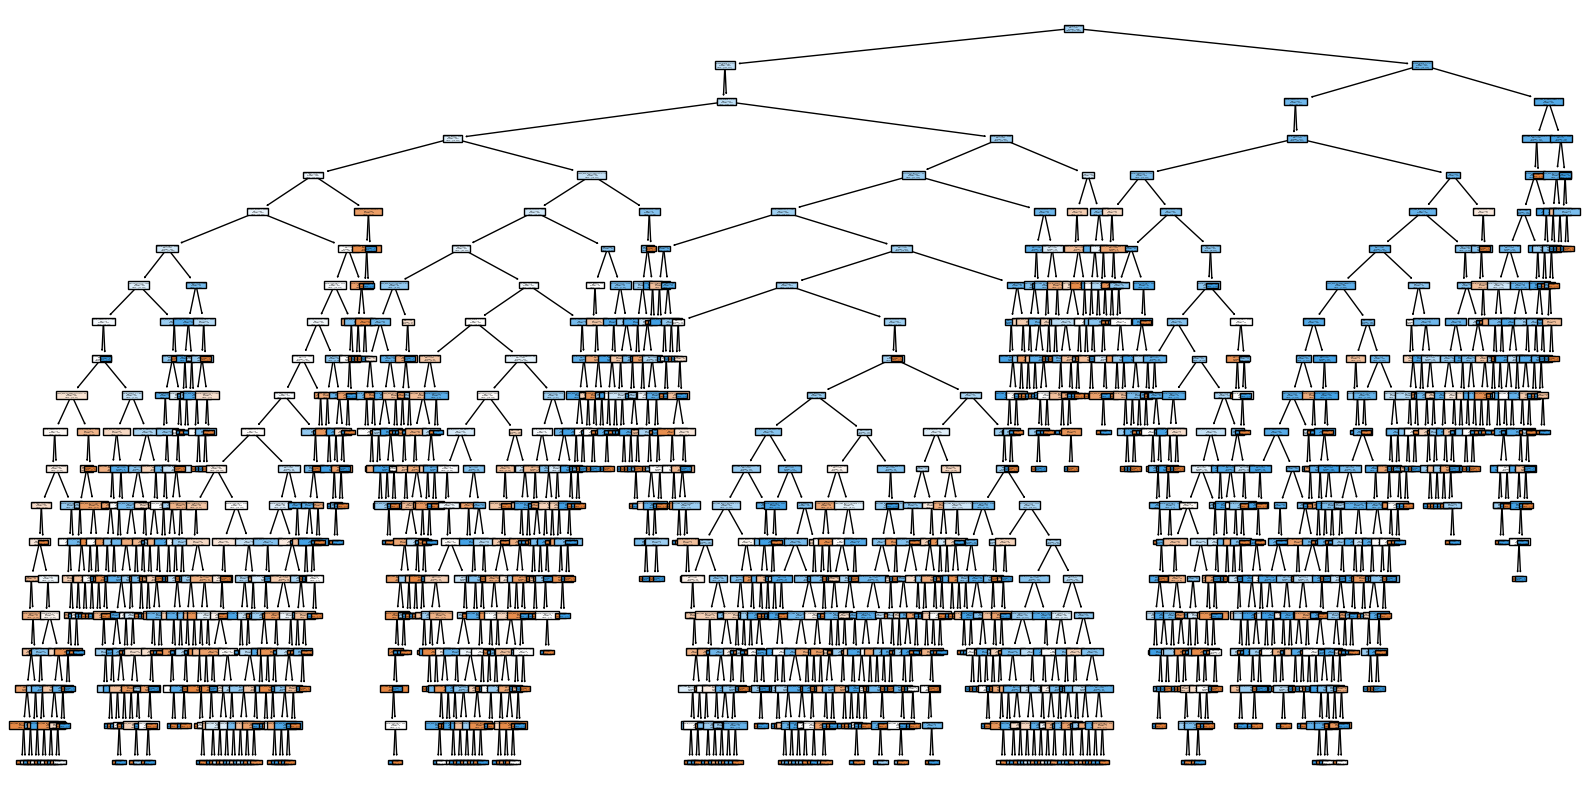

In [200]:
visualize_tree(fav_tree, fav_columns_except_target)

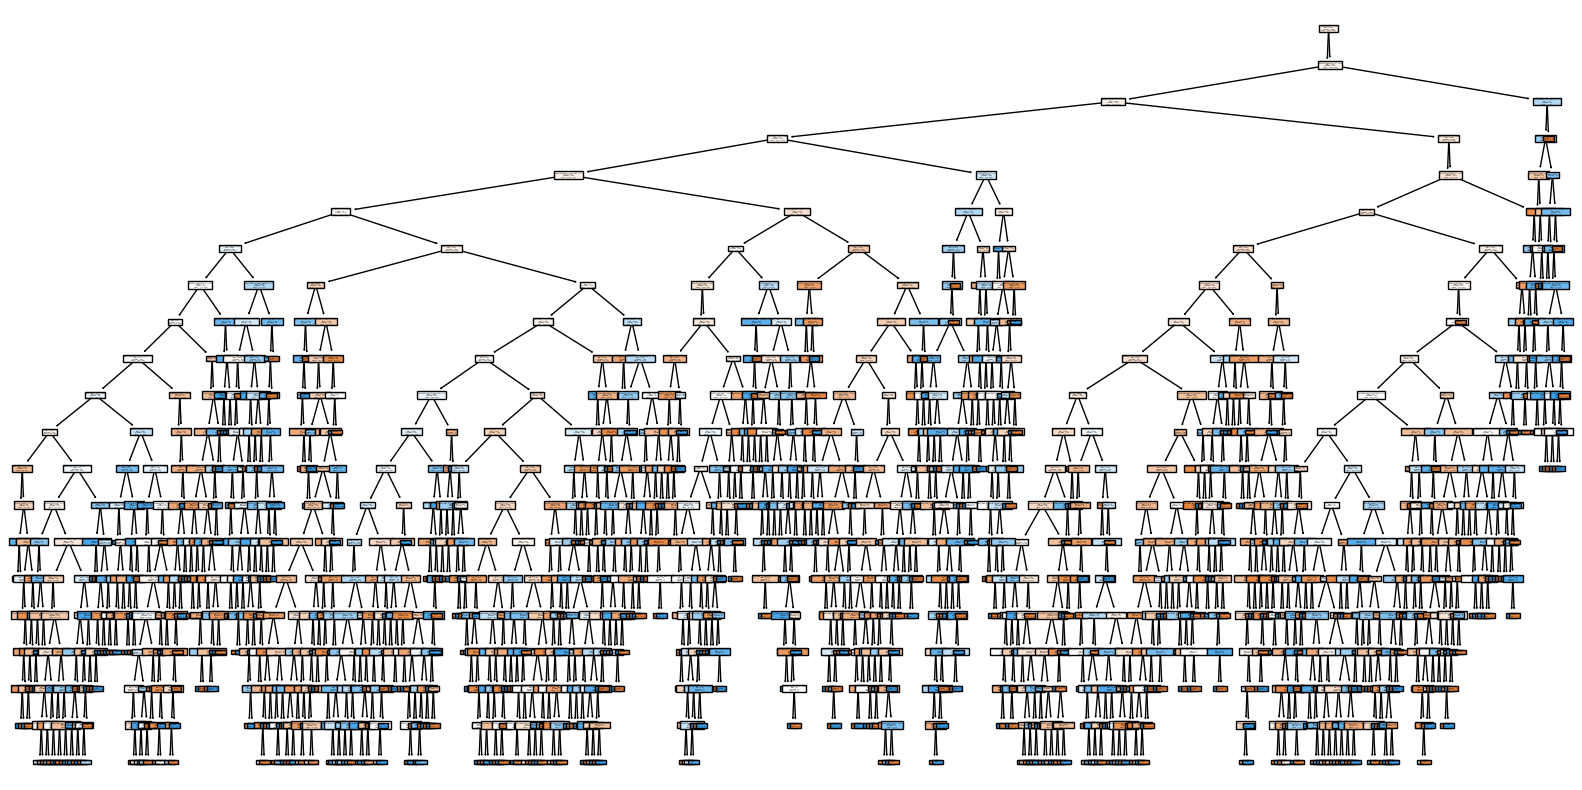

In [201]:
visualize_tree(cov_tree, cov_columns_except_target)

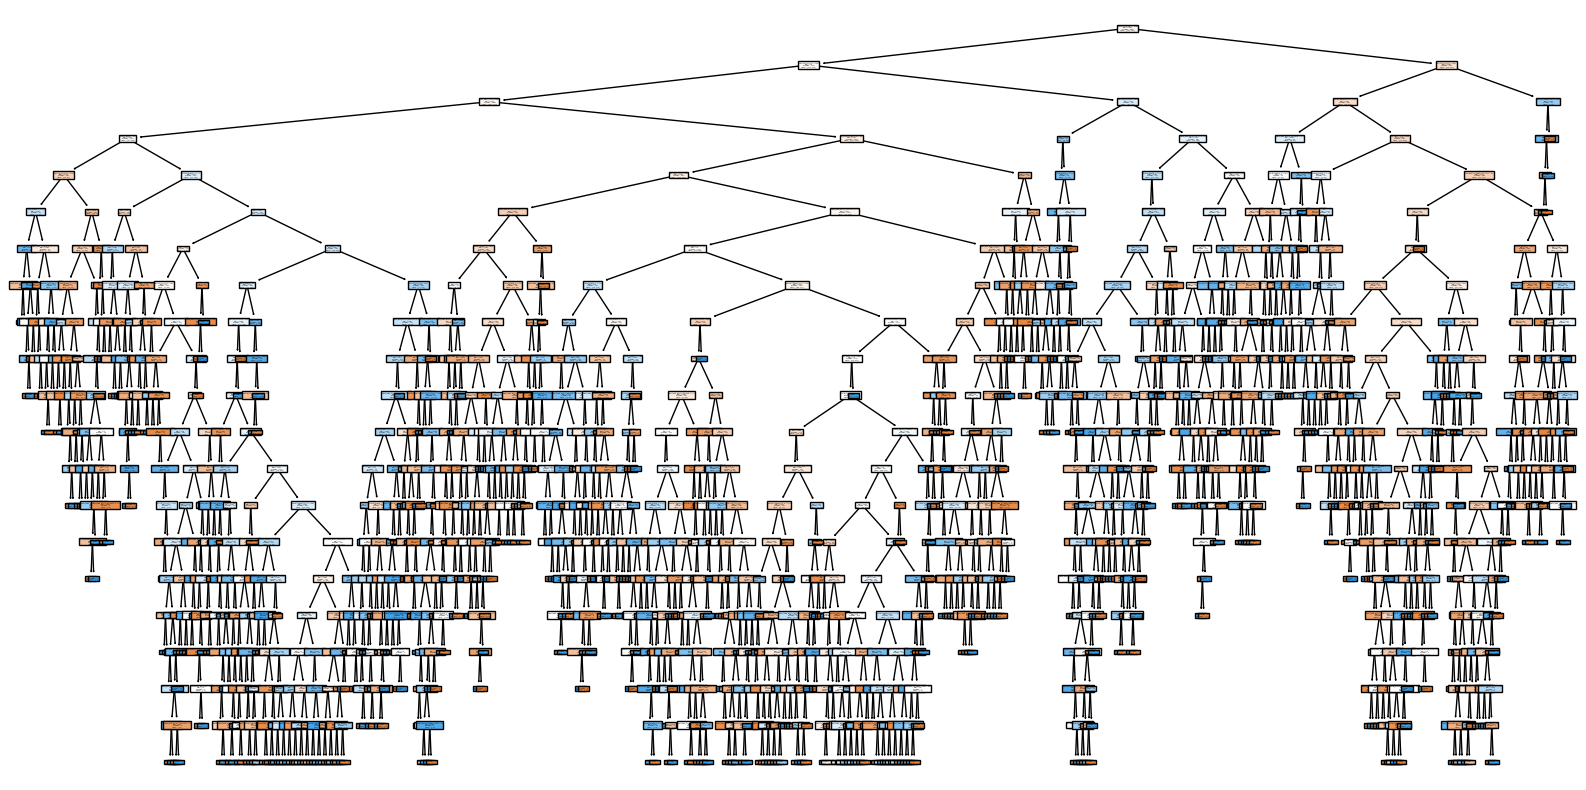

In [202]:
visualize_tree(over_tree, over_columns_except_target)

As shown in the results, decision trees can be visually complex and challenging to interpret. It is important to note that decision trees, despite their advantages, also have certain drawbacks. Overfitting is a common concern with decision trees, where the model becomes too specific to the training data and may not generalize well to unseen data. This can lead to high variance and poor performance on new observations.

Additionally, decision trees can introduce bias if the data used for training is imbalanced or if there are certain features that have a stronger influence on the outcome. This can result in the tree being skewed towards certain branches and may affect the overall accuracy and fairness of the model. (Decision Tree)

Accuracy: 0.6686332350049164


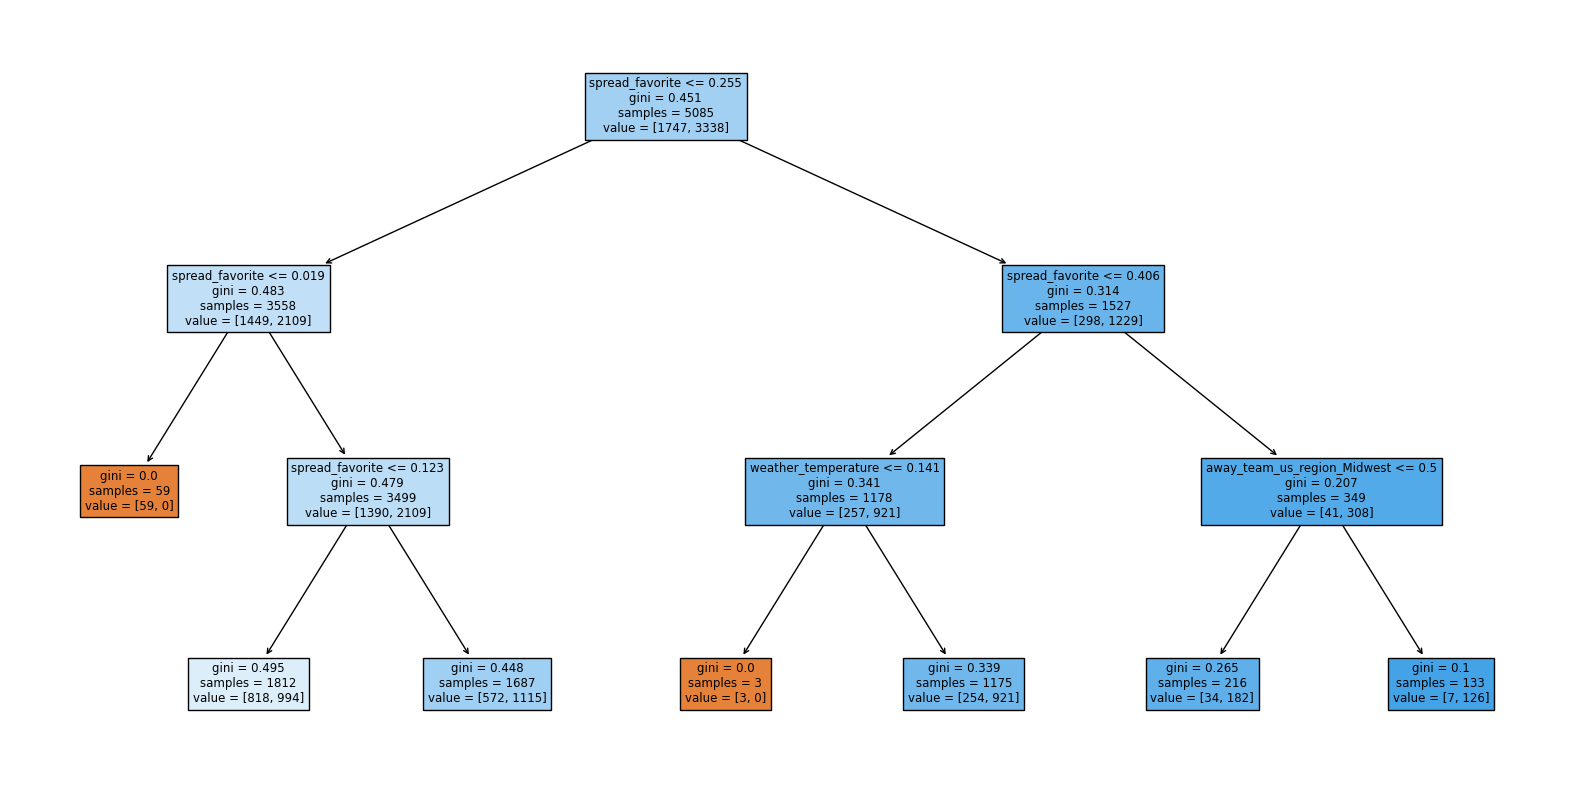

In [203]:
prune_fav_tree = decision_tree_model(fav_norm, 'did_favorite_win', fav_columns_except_target, 3)
visualize_tree(prune_fav_tree, fav_columns_except_target)

## Discussion of Results

In conclusion, this project involved exploring various methods and techniques to analyze the data. Many of my attempts and experiments didn't make it into this report, including transforming columns, dummying target columns, and applying different feature selection techniques such as Recursive Feature Elimination (RFE), Recursive Feature Elimination with Cross-Validation (RFECV), Principal Component Analysis (PCA), and Lasso. Additionally, I explored other supervised learning models like Random Forests, Naive Bayes, and k-Nearest Neighbors, but they didn't show significant improvement over the baseline.

However, let's discuss the findings presented in this report. Feature selection, although not strong overall, did reveal some significant features when ignoring the False Discovery Rate (FDR). Weather conditions, specific US regions, and team divisions were found to have the highest impact among the features tested. This aligns with expectations as adverse weather or unfamiliar climate conditions can greatly influence team performance and game outcomes. 

Although I attempted KMeans clustering, it was clear that without proper clustering and considering only one outcome, meaningful distinctions couldn't be made. For this specific problem, the decision tree model performed the best, as evident from its high accuracy. It is worth mentioning that decision trees were not extensively covered in this course, but they proved to be effective in this analysis. 

The list of features selected through the t-test and ran through the Logical Regression Model provided a slight advantage to gamblers, with an improvement in winning percentage ranging from 7% to 11%. Moving forward, I plan to test the decision tree model during the upcoming football season.

Overall, it is important to note that the dense and overlapping nature of the features in this dataset makes it challenging to extract highly meaningful or impactful insights. However, the findings and models developed in this project provide a solid starting point for further analysis and exploration in the field of football analytics.

## Resources

Initial data set: https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data?resource=download 

weather data : https://github.com/Nolanole/NFL-Weather-Project/blob/master/all_games_weather.csv

Towards Data : https://towardsdatascience.com/categorical-feature-encoding-547707acf4e5#:~:text=3.-,Why%20Encode%20Categorical%20Data%3F,that%20data%20is%20not%20numerical

Analytics Vidha : https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

Standard Deviation : https://en.wikipedia.org/wiki/Standard_deviation

Feature Selection : https://en.wikipedia.org/wiki/Feature_selection

Chi-2 : https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223#:~:text=A%20chi%2Dsquare%20test%20is,count%20O%20deviates%20each%20other

ttest : https://www.scribbr.com/statistics/t-test/#:~:text=A%20t%20test%20is%20a,are%20different%20from%20one%20another.

Kmeans : https://en.wikipedia.org/wiki/K-means_clustering#:~:text=k%2Dmeans%20clustering%20is%20a,a%20prototype%20of%20the%20cluster.

Decision Tree : https://en.wikipedia.org/wiki/Decision_tree_learning